# CNN Pruning via Two-Phase Evolutionary Optimization - **ResNet101**
---
#### **author**: Zak Khan
#### **email:** khan1132@mylaurier.ca
#### **program:** Master of Applied Computing
#### **school:** Wilfrid Laurier University
#### **last updated:** May 9, 2025
---
#### **Research Description:**

This research explores a two-phase pruning framework for compressing deep convolutional neural networks (CNNs) using evolutionary algorithms.

- **Phase 1** performs continuous pruning by assigning real-valued importance scores to individual weights. A Pareto front is generated using NSGA-II to optimize the trade-off between accuracy and sparsity. The best model (based on accuracy and non-zero weight count) is selected as the starting point for Phase 2.

- **Phase 2** applies a second layer of pruning using **structured filter pruning** at the convolutional layer level. Each individual encodes a pruning ratio and importance heuristic for each layer. NSGA-II is again used to optimize a population of pruning configurations over generations. The result is a set of compact models with competitive accuracy and reduced size, inspired by the WIEA pruning strategy.

Together, the two phases aim to produce **highly sparse, high-performing CNNs** that are efficient to deploy while preserving task performance. 


---

## Setup

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import psutil
import pickle
import copy
import pymoo
import os
import json

from torchvision import models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.core.population import Population
from pymoo.core.sampling import Sampling
from copy import deepcopy

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### System Specifications

In [2]:
# Get CPU Info
print("CPU INFO")
print(f"CPU Cores: {psutil.cpu_count(logical=True)}")
print(f"CPU Frequency: {(psutil.cpu_freq()).max:.2f} MHz")
print(f"CPU Usage: {psutil.cpu_percent(interval=1)}%")

# Get GPU info
if torch.cuda.is_available():
    print("\nGPU INFO:")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU detected")

CPU INFO
CPU Cores: 32
CPU Frequency: 4001.00 MHz
CPU Usage: 0.9%

GPU INFO:
GPU is available: NVIDIA RTX A6000
CUDA Version: 11.8
Total VRAM: 51.53 GB


### Retrieving Dataset and CNN Architecture

In [3]:
# Load original pretrained ResNet model and calculate total number of parameters
original_resnet = models.resnet101(pretrained=True)  

total_params = sum(p.numel() for p in original_resnet.parameters())
trainable_params = sum(p.numel() for p in original_resnet.parameters() if p.requires_grad)

print(f"\nTotal parameters in original ResNet101: {total_params:,}")
print(f"Trainable parameters in original ResNet101: {trainable_params:,}")

C:\Users\Zahaak\anaconda3\envs\ai-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Zahaak\anaconda3\envs\ai-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Zahaak/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100.0%



Total parameters in original ResNet101: 44,549,160
Trainable parameters in original ResNet101: 44,549,160


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(0))

# Modify ResNet101 for 10 classes
model = models.resnet101(pretrained=True)  # Change model size if needed
model.fc = nn.Linear(model.fc.in_features, 10)  # Change output layer for 10 classes
model = model.to(device)  # Move model to GPU
model.eval()

#print("\nModel Architecture:\n", model)

Using device: cuda
NVIDIA RTX A6000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# Natural pruning from compressing 
total_params_2 = sum(p.numel() for p in model.parameters())
trainable_params_2 = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters in condensed ResNet101 (10 classes): {total_params_2:,}")
print(f"Trainable parameters in condensed ResNet101 (10 classes): {trainable_params_2:,}")

Total parameters in condensed ResNet101 (10 classes): 42,520,650
Trainable parameters in condensed ResNet101 (10 classes): 42,520,650


In [7]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Download CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Fine-Tune on the Entire Training Set (50k Samples)
train_loader_full = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [8]:
print(f"Training Set Size: {len(train_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")

Training Set Size: 50000
Test Set Size: 10000


### Creating Subset and Validation Set

In [9]:
# Subset for Optimization: training images by class and sample 50 images per class
class_to_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(train_dataset):
    class_to_indices[label].append(idx)

train_indices = []
for class_label, indices in class_to_indices.items():
    sampled_indices = random.sample(indices, 100)
    train_indices.extend(sampled_indices)

train_subset = Subset(train_dataset, train_indices)
train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True, pin_memory=True)

print(f"Training Subset Size: {len(train_subset)}")

Training Subset Size: 1000


In [10]:
all_train_indices = set(range(len(train_dataset)))  # All available indices in training set
subset_indices = set(train_indices)  # Indices used in the 500-sample subset
remaining_indices = list(all_train_indices - subset_indices)  # Remaining indices for validation

validation_indices = random.sample(remaining_indices, 2000)
validation_subset = Subset(train_dataset, validation_indices)
validation_loader = DataLoader(validation_subset, batch_size=32, shuffle=False, pin_memory=True)

print(f"Validation Set Size: {len(validation_subset)}")

Validation Set Size: 2000


## Baseline Model (All Parameters)

### Finetuning Model

In [11]:
# Fine-Tune the Model on the Full Training Set
def finetune_model(model, train_loader, num_epochs=10, learning_rate=0.0001):

    model.train()  # Set model to training mode
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()               # Reset gradients
            outputs = model(inputs)             # Forward pass
            loss = criterion(outputs, labels)   # Compute loss
            loss.backward()                     # Backpropagation
            optimizer.step()                    # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

In [12]:
print("Fine-tuning the model on entire CIFAR-10 training set:")
finetune_model(model, train_loader_full, num_epochs=10, learning_rate=0.0001)

Fine-tuning the model on entire CIFAR-10 training set:
Epoch 1/10, Loss: 503.1218, Accuracy: 89.36%
Epoch 2/10, Loss: 242.1998, Accuracy: 94.85%
Epoch 3/10, Loss: 176.6365, Accuracy: 96.18%
Epoch 4/10, Loss: 133.4247, Accuracy: 97.10%
Epoch 5/10, Loss: 109.9902, Accuracy: 97.66%
Epoch 6/10, Loss: 88.9612, Accuracy: 98.11%
Epoch 7/10, Loss: 85.5180, Accuracy: 98.16%
Epoch 8/10, Loss: 75.9091, Accuracy: 98.44%
Epoch 9/10, Loss: 68.4559, Accuracy: 98.56%
Epoch 10/10, Loss: 60.9375, Accuracy: 98.76%


### Baseline Accuracy

In [13]:
# Test the model's baseline accuracy after fine-tuning
def test_baseline_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    baseline_accuracy = correct / total * 100

    print(f"Baseline accuracy after fine-tuning on training set (50K): {baseline_accuracy:.2f}%")
    return baseline_accuracy

baseline_accuracy = test_baseline_accuracy(model, test_loader)

Baseline accuracy after fine-tuning on training set (50K): 95.01%


## Phase 1 Weight Pruning
---
Continuous Threshold-Based Weight Pruning using NSGA-II:

Solving a multi-objective optimization problem where each solution (individual) is defined by two real-valued thresholds: **th1** and **th2**

**Objectives**: For each candidate solution [th1, th2]:

- Minimize non-zero weights (i.e., increase sparsity / pruning rate)

- Minimize classification error (i.e., retain high accuracy)

In [14]:
# directory for saving phase 1 models
save_dir = "resnet101_phase_1_saved_models"
os.makedirs(save_dir, exist_ok=True)

In [15]:
class PhaseOneWeightPruningProblem(Problem):
    
    def __init__(self, model, dataloader):
        super().__init__(
            n_var=2,                      # Decision variables: [th1, th2]
            n_obj=2,                      # Objectives: [non-zero weights, classification error]
            n_constr=0,                   # No constraints
            xl=np.array([-0.05, 0]),      # Boundaries for pruning thresholds
            xu=np.array([0, 0.05])
        )
        self.model = model
        self.dataloader = dataloader
        self.initial_population = None  # Store initial population

    def _evaluate(self, X, out, *args, **kwargs):
        
        if self.initial_population is None:
            self.initial_population = X.copy()
            np.save(os.path.join(save_dir, "initial_population.npy"), self.initial_population)  # Save initial population

        f1, f2 = [], []  # Store objectives

        for th1, th2 in X:
            acc, non_zero_weights = evaluate_individual(th1, th2, self.model, self.dataloader)
            f1.append(non_zero_weights)
            f2.append(1 - acc)

        out["F"] = np.column_stack([f1, f2])  # Store objectives

def prune_weights(model, th1, th2):
    # Safety check to ensure th1 <= th2
    if th1 > th2:
        th1, th2 = th2, th1  # Swap
    
    pruned_model = deepcopy(model)
    with torch.no_grad():
        for param in pruned_model.parameters():
            mask = (param.data >= th1) & (param.data <= th2)
            param.data[mask] = 0.0  
    return pruned_model

def evaluate_individual(th1, th2, model, dataloader):
    pruned_model = prune_weights(model, th1, th2)
    pruned_model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pruned_model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    non_zero_weights = sum((p != 0).sum().item() for p in pruned_model.parameters())

    return accuracy, non_zero_weights

In [16]:
# Use a custom callback in pymoo to save the Pareto front at every 10th generation.
from pymoo.core.callback import Callback

class SaveParetoFrontCallback(Callback):
    def __init__(self, save_interval=10):
        super().__init__()
        self.save_interval = save_interval
        self.saved_generations = []

    def notify(self, algorithm):
        generation = algorithm.n_gen
        if generation % self.save_interval == 0:
            X = algorithm.pop.get("X")
            F = algorithm.pop.get("F")

            gen_dir = os.path.join(save_dir, "pareto_fronts_across_generations")
            os.makedirs(gen_dir, exist_ok=True)

            np.save(os.path.join(gen_dir, f"gen_{generation}_X.npy"), X)
            np.save(os.path.join(gen_dir, f"gen_{generation}_F.npy"), F)

            self.saved_generations.append(generation)

### Running NSGA-II

In [17]:
# Run NSGA-II Optimization
def run_nsga2(model, dataloader):
    
    problem = PhaseOneWeightPruningProblem(model, dataloader)
    callback = SaveParetoFrontCallback(save_interval=10)
    
    algorithm = NSGA2(
        pop_size=50,  
        sampling=LHS(),  
        crossover=SBX(prob=0.9, eta=15),  
        mutation=PM(prob=0.2, eta=20),  
        eliminate_duplicates=True  
    )

    result = minimize(problem, algorithm, termination=("n_gen", 50), seed=42, verbose=True,  callback=callback)
    np.save(os.path.join(save_dir, "final_population.npy"), result.pop.get("X")) # Save final population

    return result

In [18]:
print("Running Phase-1 NSGA-II Optimizer on ResNet101:")
result = run_nsga2(model, train_loader_subset)

Running Phase-1 NSGA-II Optimizer on ResNet101:
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      4 |             - |             -
     2 |      100 |      6 |  0.0206627363 |             f
     3 |      150 |      6 |  0.0111607143 |         ideal
     4 |      200 |      8 |  0.0026553785 |         ideal
     5 |      250 |     10 |  0.0423299318 |             f
     6 |      300 |     14 |  0.0319098260 |             f
     7 |      350 |     16 |  0.0115839222 |             f
     8 |      400 |     19 |  0.0131825498 |             f
     9 |      450 |     16 |  0.5634943718 |         nadir
    10 |      500 |     18 |  0.0050996398 |             f
    11 |      550 |     18 |  0.0122533053 |             f
    12 |      600 |     17 |  0.0101902593 |             f
    13 |      650 |     23 |  0.0115570932 |             f
    14 |      700 |     28 |  0.0086131732 |             f
    15 |      750 |     34 |  0.0028657873 |             f
    16 |

### Cache Phase 1 Optimization Results

In [19]:
def cache_pruned_models_and_metrics(result, model, validation_loader, test_loader):
    cached_models = []
    validation_accuracies = []
    test_accuracies = []
    non_zero_weights_list = []

    for th1, th2 in result.X:
        # Ensure thresholds are in correct order
        th1, th2 = min(th1, th2), max(th1, th2)

        # Prune model
        pruned_model = prune_weights(model, th1, th2)

        # Evaluate on validation set
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = pruned_model(inputs)
                _, predicted = outputs.max(1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        validation_accuracy = correct_val / total_val
        validation_accuracies.append(validation_accuracy)

        # Evaluate on test set
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = pruned_model(inputs)
                _, predicted = outputs.max(1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)
        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)

        # Count remaining non-zero weights
        non_zero_weights = sum((p != 0).sum().item() for p in pruned_model.parameters())
        non_zero_weights_list.append(non_zero_weights)

        # Store (Th1, Th2, pruned_model) to allow retrieval later
        cached_models.append((th1, th2, pruned_model))  

    # Save the results
    np.save(os.path.join(save_dir, "cached_models.npy"), cached_models, allow_pickle=True)
    np.save(os.path.join(save_dir, "validation_accuracies.npy"), validation_accuracies)
    np.save(os.path.join(save_dir, "test_accuracies.npy"), test_accuracies)
    np.save(os.path.join(save_dir, "non_zero_weights.npy"), non_zero_weights_list)

    # Save results as CSV
    df = pd.DataFrame([(m[0], m[1]) for m in cached_models], columns=["Th1", "Th2"])
    df["Validation Accuracy"] = validation_accuracies
    df["Test Accuracy"] = test_accuracies
    df["Non-Zero Weights"] = non_zero_weights_list
    df.to_csv(os.path.join(save_dir, "cached_metrics.csv"), index=False)

    print(f"Cached metrics saved in {save_dir}/cached_metrics.csv")

    return cached_models, validation_accuracies, test_accuracies, non_zero_weights_list

# Cache pruned models and precompute metrics
cached_models, validation_accuracies, test_accuracies, non_zero_weights_list = cache_pruned_models_and_metrics(
    result, model, validation_loader, test_loader
)

Cached metrics saved in resnet101_phase_1_saved_models/cached_metrics.csv


### Outputs Phase 1 Pruning

In [20]:
def represent_population(label="Initial Population"):
    
    if label == "Initial Population":
        population = np.load(os.path.join(save_dir, "initial_population.npy"))
        table_filename = os.path.join(save_dir, "initial_population.csv")
    else:
        population = np.load(os.path.join(save_dir, "final_population.npy"))
        table_filename = os.path.join(save_dir, "final_population.csv")

    # Load objectives only for final population
    objectives = None
    if label == "Final Population":
        objectives = result.pop.get("F")  # Extract objectives for final population

    print(f"\n{label}:\n")
    population_data = []

    for i, (th1, th2) in enumerate(population):
        if objectives is not None:
            non_zero_weights = objectives[i, 0]
            classification_error = objectives[i, 1]
            print(f"Solution {i + 1}: Th1 = {th1:.6f}, Th2 = {th2:.6f}, Non-Zero Weights = {non_zero_weights:.0f}, Classification Error = {classification_error:.6f}")
            population_data.append([th1, th2, non_zero_weights, classification_error])
        else:
            print(f"Solution {i + 1}: Th1 = {th1:.6f}, Th2 = {th2:.6f}")
            population_data.append([th1, th2])

    # Convert to DataFrame and save to CSV
    if objectives is not None:
        df = pd.DataFrame(population_data, columns=["Th1", "Th2", "Non-Zero Weights", "Classification Error"])
    else:
        df = pd.DataFrame(population_data, columns=["Th1", "Th2"])

    df.to_csv(table_filename, index=False)
    print(f"{label} saved to {table_filename}")

# Represent and save both populations
represent_population(label="Initial Population")
represent_population(label="Final Population")    


Initial Population:

Solution 1: Th1 = -0.045052, Th2 = 0.002469
Solution 2: Th1 = -0.027541, Th2 = 0.018363
Solution 3: Th1 = -0.004726, Th2 = 0.042024
Solution 4: Th1 = -0.038516, Th2 = 0.045677
Solution 5: Th1 = -0.046795, Th2 = 0.000729
Solution 6: Th1 = -0.002439, Th2 = 0.049922
Solution 7: Th1 = -0.018025, Th2 = 0.041037
Solution 8: Th1 = -0.048836, Th2 = 0.029304
Solution 9: Th1 = -0.022409, Th2 = 0.004827
Solution 10: Th1 = -0.032156, Th2 = 0.019750
Solution 11: Th1 = -0.037549, Th2 = 0.048285
Solution 12: Th1 = -0.031660, Th2 = 0.006720
Solution 13: Th1 = -0.005955, Th2 = 0.007262
Solution 14: Th1 = -0.024554, Th2 = 0.012388
Solution 15: Th1 = -0.041420, Th2 = 0.034752
Solution 16: Th1 = -0.015356, Th2 = 0.026242
Solution 17: Th1 = -0.008014, Th2 = 0.040884
Solution 18: Th1 = -0.026046, Th2 = 0.046959
Solution 19: Th1 = -0.006855, Th2 = 0.011296
Solution 20: Th1 = -0.012474, Th2 = 0.021902
Solution 21: Th1 = -0.044492, Th2 = 0.025527
Solution 22: Th1 = -0.020173, Th2 = 0.0135

In [21]:
def select_best_individual(cached_models, validation_accuracies):
    if not cached_models or not validation_accuracies:
        print("Error: Cached models or validation accuracies are empty.")
        return None

    # Get the best individual (highest validation accuracy)
    best_index = np.argmax(validation_accuracies)
    best_model_data = cached_models[best_index]
    best_accuracy = validation_accuracies[best_index]

    print(f"Best individual on validation set: Th1 = {best_model_data[0]:.6f}, Th2 = {best_model_data[1]:.6f}, Accuracy = {best_accuracy:.4f}")

    # Save the best model thresholds
    best_model_path = os.path.join(save_dir, "best_model_thresholds.npy")
    np.save(best_model_path, np.array(best_model_data))
    print(f"Best model thresholds saved at: {best_model_path}")

    return best_model_data

# Select the best individual based on validation set
best_model_data = select_best_individual(cached_models, validation_accuracies)

Best individual on validation set: Th1 = -0.013615, Th2 = 0.013211, Accuracy = 0.9920
Best model thresholds saved at: resnet101_phase_1_saved_models\best_model_thresholds.npy


In [22]:
def evaluate_best_on_test(best_model_data, model, test_loader):
    
    # Extract thresholds
    th1, th2, _ = best_model_data  

    # Prune the model using the best thresholds
    pruned_model = prune_weights(model, th1, th2)
    pruned_model.to(device)  # Move model to the same device as inputs
    pruned_model.eval()      # Set model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure inputs are on the same device
            outputs = pruned_model(inputs)  # Forward pass
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate test accuracy
    test_accuracy = correct / total  
    print(f"Test accuracy of the best individual (Th1={th1:.6f}, Th2={th2:.6f}): {test_accuracy:.4f}")

    # Save test accuracy for later reference
    test_accuracy_path = os.path.join(save_dir, "best_model_test_accuracy.npy")
    np.save(test_accuracy_path, np.array([th1, th2, test_accuracy]))
    print(f"Test accuracy saved at: {test_accuracy_path}")

    return test_accuracy

test_accuracy_of_best = evaluate_best_on_test(best_model_data, model, test_loader)

Test accuracy of the best individual (Th1=-0.013615, Th2=0.013211): 0.9432
Test accuracy saved at: resnet101_phase_1_saved_models\best_model_test_accuracy.npy


In [23]:
def generate_pruning_table_with_delta(cached_models, test_accuracies, non_zero_weights_list, baseline_accuracy, model):
    table = []

    # Get the total number of weights in the full (unpruned) model
    total_weights = sum(p.numel() for p in model.parameters())

    for (th1, th2, _), test_accuracy, non_zero_weights in zip(cached_models, test_accuracies, non_zero_weights_list):
        pruned_weights = total_weights - non_zero_weights  # Calculate number of pruned weights
        pruned_rate = pruned_weights / total_weights  # Calculate pruning rate
        delta_acc = test_accuracy - baseline_accuracy  # Change in accuracy compared to baseline

        table.append([th1, th2, pruned_weights, pruned_rate, test_accuracy, delta_acc])

    return table

# Compute baseline accuracy (unpruned model)
baseline_accuracy = max(test_accuracies)  # Adjust this to use your actual unpruned model test accuracy

# Generate pruning table with delta accuracy
pruning_table = generate_pruning_table_with_delta(
    cached_models, test_accuracies, non_zero_weights_list, baseline_accuracy, model
)

# Convert to DataFrame and save as CSV
df = pd.DataFrame(pruning_table, columns=["Th1", "Th2", "#Pruned", "Rate Pruned", "Acc", "Delta Acc"])
csv_path = os.path.join(save_dir, "pruning_table_phase_1.csv")
df.to_csv(csv_path, index=False)

# Print output
print(df)
print(f"Pruning table saved at: {csv_path}")

         Th1       Th2   #Pruned  Rate Pruned     Acc  Delta Acc
0  -0.049998  0.049999  42111257     0.990372  0.0996    -0.8436
1  -0.013615  0.013211  26482265     0.622810  0.9432     0.0000
2  -0.016818  0.015463  30082239     0.707474  0.8729    -0.0703
3  -0.019954  0.019252  33642843     0.791212  0.8282    -0.1150
4  -0.049010  0.049933  42094556     0.989979  0.1166    -0.8266
5  -0.030003  0.030816  39700118     0.933667  0.1334    -0.8098
6  -0.015005  0.014439  28278541     0.665054  0.9356    -0.0076
7  -0.028540  0.027625  38922899     0.915388  0.2309    -0.7123
8  -0.015845  0.015233  29319235     0.689529  0.9309    -0.0123
9  -0.020738  0.019854  34255157     0.805612  0.7935    -0.1497
10 -0.014437  0.013983  27591378     0.648894  0.9392    -0.0040
11 -0.020143  0.019276  33745553     0.793627  0.8315    -0.1117
12 -0.024808  0.023810  37101440     0.872551  0.4748    -0.4684
13 -0.021210  0.020167  34587468     0.813428  0.7656    -0.1776
14 -0.028071  0.027089  3

### Pareto Fronts - Phase 1 Pruning

In [24]:
# def plot_pareto_fronts_across_generations():
#     gen_dir = os.path.join(save_dir, "pareto_fronts_across_generations")
#     if not os.path.exists(gen_dir):
#         print(f"Directory not found: {gen_dir}")
#         return

#     generations = sorted([int(f.split("_")[1]) for f in os.listdir(gen_dir) if f.endswith("_F.npy")])
#     plt.figure(figsize=(10, 6))

#     for gen in generations:
#         F = np.load(os.path.join(gen_dir, f"gen_{gen}_F.npy"))
#         plt.scatter(F[:, 0], 1 - F[:, 1], label=f"Gen {gen}", alpha=0.6)  # Remember: f2 = 1 - acc

#     plt.xlabel("Non-Zero Weights")
#     plt.ylabel("Accuracy")
#     plt.title("Pareto Front Evolution Across Generations")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()

#     plot_path = os.path.join(save_dir, "pareto_front_evolution.png")
#     plt.savefig(plot_path, dpi=300)
#     plt.show()
#     print(f"Pareto front evolution plot saved at: {plot_path}")

# plot_pareto_fronts_across_generations()

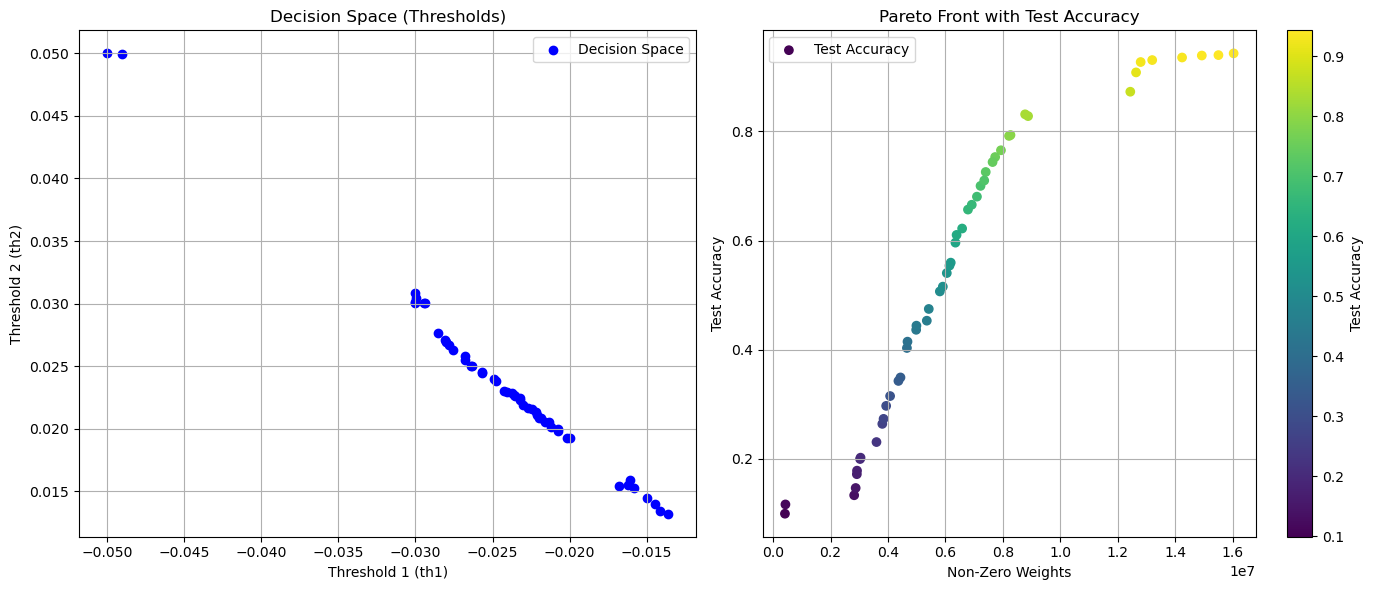

Pareto front plot saved at: resnet101_phase_1_saved_models\phase_1_pareto_front.png


In [25]:
def plot_pareto_with_cached_metrics(result, non_zero_weights_list, test_accuracies):
    if not non_zero_weights_list or not test_accuracies:
        print("Error: Non-zero weights or test accuracies are empty. Cannot plot Pareto front.")
        return None

    # Extract decision variables (thresholds) and objectives
    decision_space = result.pop.get("X")  # Thresholds (th1, th2)
    objective_space = result.pop.get("F")  # Non-zero weights and classification error

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Decision Space Plot (Thresholds)
    plt.subplot(1, 2, 1)
    plt.scatter(decision_space[:, 0], decision_space[:, 1], c="blue", label="Decision Space")
    plt.xlabel("Threshold 1 (th1)")
    plt.ylabel("Threshold 2 (th2)")
    plt.title("Decision Space (Thresholds)")
    plt.grid()
    plt.legend()

    # Objective Space Plot (Non-Zero Weights vs. Test Accuracy)
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(non_zero_weights_list, test_accuracies, c=test_accuracies, cmap="viridis", label="Test Accuracy")
    plt.colorbar(scatter, label="Test Accuracy")
    plt.xlabel("Non-Zero Weights")
    plt.ylabel("Test Accuracy")
    plt.title("Pareto Front with Test Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.join(save_dir, "phase_1_pareto_front.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"Pareto front plot saved at: {plot_path}")

plot_pareto_with_cached_metrics(result, non_zero_weights_list, test_accuracies)

In [26]:
# Save the solutions to a text file
solutions_path = os.path.join(save_dir, "non_dominated_solutions.txt")
with open(solutions_path, "w") as f:
    for i, (th1, th2, _) in enumerate(cached_models):  # Only (th1, th2) are stored
        output = (
            f"Non-Dominated Solution {i+1}:\n"
            f"  Thresholds: Th1 = {th1:.6f}, Th2 = {th2:.6f}\n"
            f"  Validation Accuracy: {validation_accuracies[i]:.4f}\n"
            f"  Test Accuracy: {test_accuracies[i]:.4f}\n"
            f"  Non-Zero Weights: {non_zero_weights_list[i]}\n\n"
        )
        print(output)  
        f.write(output) 

print(f"Non-dominated solutions saved at: {solutions_path}")

Non-Dominated Solution 1:
  Thresholds: Th1 = -0.049998, Th2 = 0.049999
  Validation Accuracy: 0.0905
  Test Accuracy: 0.0996
  Non-Zero Weights: 409393


Non-Dominated Solution 2:
  Thresholds: Th1 = -0.013615, Th2 = 0.013211
  Validation Accuracy: 0.9920
  Test Accuracy: 0.9432
  Non-Zero Weights: 16038385


Non-Dominated Solution 3:
  Thresholds: Th1 = -0.016818, Th2 = 0.015463
  Validation Accuracy: 0.9385
  Test Accuracy: 0.8729
  Non-Zero Weights: 12438411


Non-Dominated Solution 4:
  Thresholds: Th1 = -0.019954, Th2 = 0.019252
  Validation Accuracy: 0.8780
  Test Accuracy: 0.8282
  Non-Zero Weights: 8877807


Non-Dominated Solution 5:
  Thresholds: Th1 = -0.049010, Th2 = 0.049933
  Validation Accuracy: 0.1145
  Test Accuracy: 0.1166
  Non-Zero Weights: 426094


Non-Dominated Solution 6:
  Thresholds: Th1 = -0.030003, Th2 = 0.030816
  Validation Accuracy: 0.1275
  Test Accuracy: 0.1334
  Non-Zero Weights: 2820532


Non-Dominated Solution 7:
  Thresholds: Th1 = -0.015005, Th2 = 0

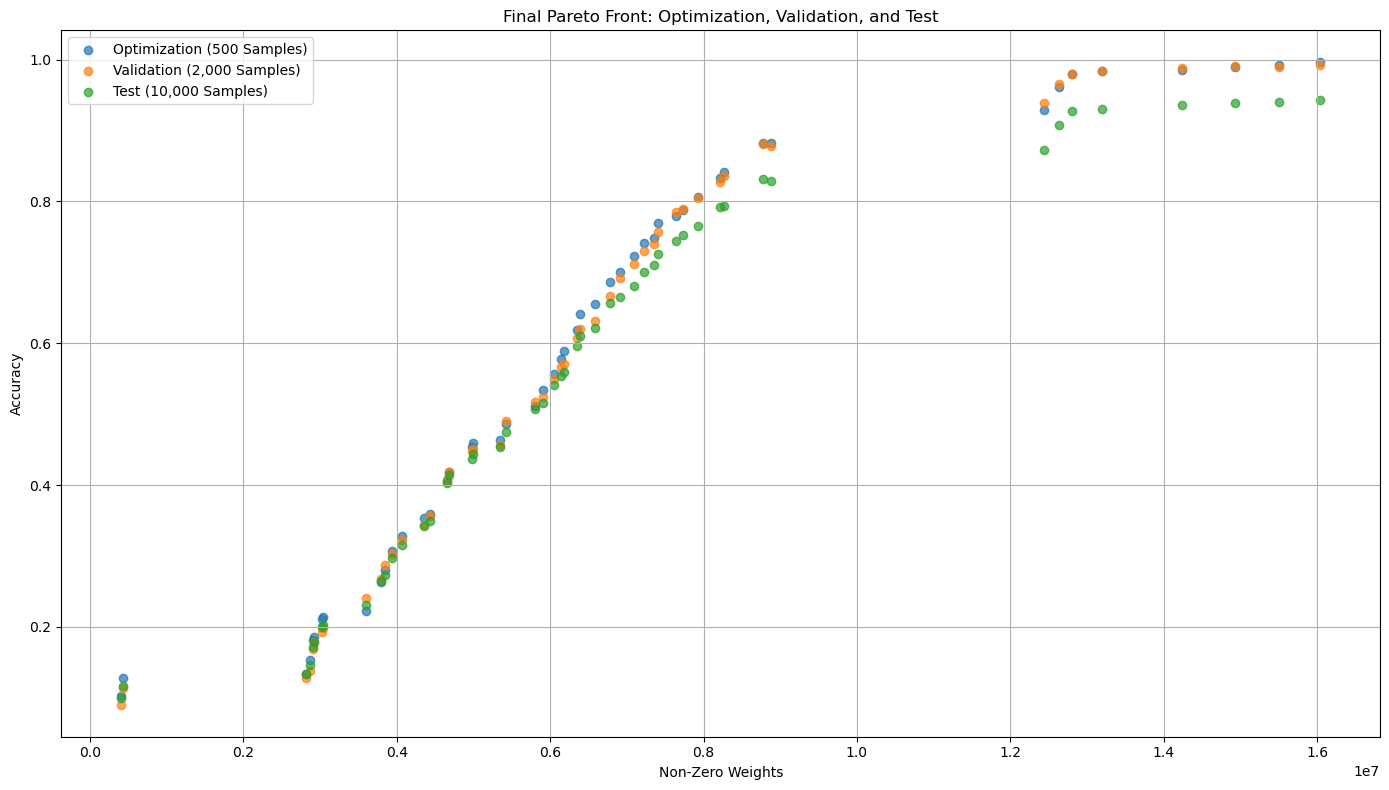

Final Pareto front plot saved at: resnet101_phase_1_saved_models\final_pareto_front_train_valid_test.png


In [27]:
def plot_final_pareto_front(result, optimization_accuracies, validation_accuracies, test_accuracies, non_zero_weights_list):
    if not optimization_accuracies or not validation_accuracies or not test_accuracies:
        print("Error: One of the accuracy lists is empty. Cannot plot Pareto front.")
        return None

    plt.figure(figsize=(14, 8))

    # Plot Pareto front for optimization set (500 samples)
    plt.scatter(non_zero_weights_list, optimization_accuracies, label="Optimization (500 Samples)", alpha=0.7)

    # Plot Pareto front for validation set (2,000 samples)
    plt.scatter(non_zero_weights_list, validation_accuracies, label="Validation (2,000 Samples)", alpha=0.7)

    # Plot Pareto front for test set (10,000 samples)
    plt.scatter(non_zero_weights_list, test_accuracies, label="Test (10,000 Samples)", alpha=0.7)

    plt.xlabel("Non-Zero Weights")
    plt.ylabel("Accuracy")
    plt.title("Final Pareto Front: Optimization, Validation, and Test")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plot_path = os.path.join(save_dir, "final_pareto_front_train_valid_test.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"Final Pareto front plot saved at: {plot_path}")

# Extract Pareto front thresholds
pareto_solutions = result.pop.get("X") if result else []

# Compute optimization accuracies
optimization_accuracies = []
non_zero_weights_list = []

for th1, th2 in pareto_solutions:
    accuracy, non_zero_weights = evaluate_individual(th1, th2, model, train_loader_subset)
    optimization_accuracies.append(accuracy)
    non_zero_weights_list.append(non_zero_weights)

# Plot the final Pareto front
plot_final_pareto_front(
    result=result,
    optimization_accuracies=optimization_accuracies,
    validation_accuracies=validation_accuracies,
    test_accuracies=test_accuracies,
    non_zero_weights_list=non_zero_weights_list
)

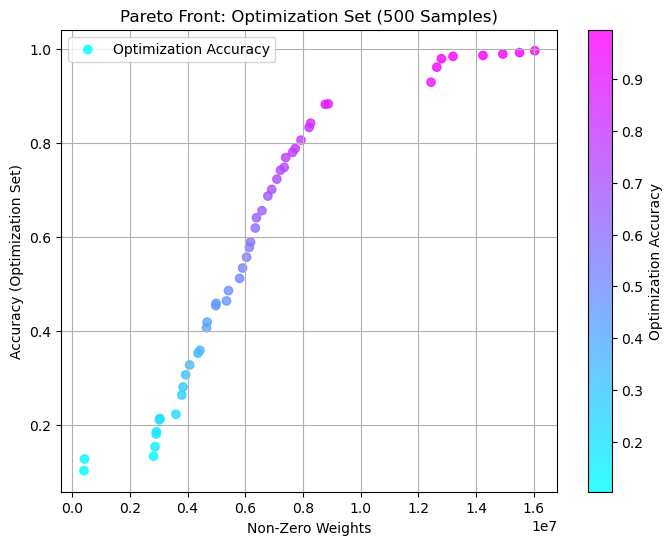

Optimization Pareto front plot saved at: resnet101_phase_1_saved_models\pareto_front_optimization.png


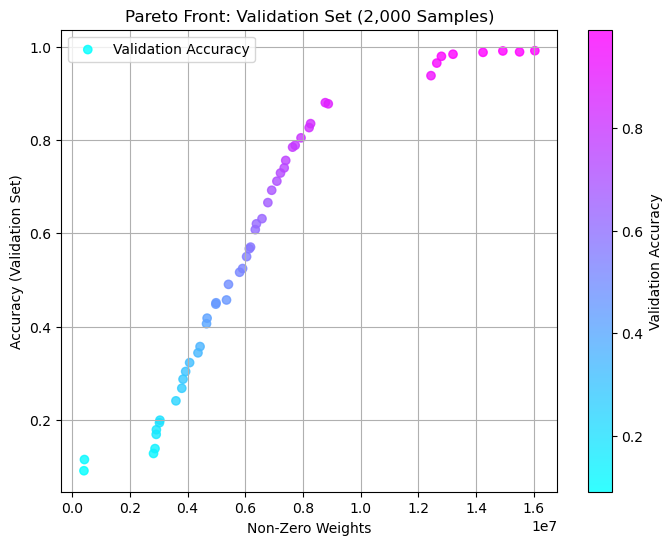

Validation Pareto front plot saved at: resnet101_phase_1_saved_models\pareto_front_validation.png


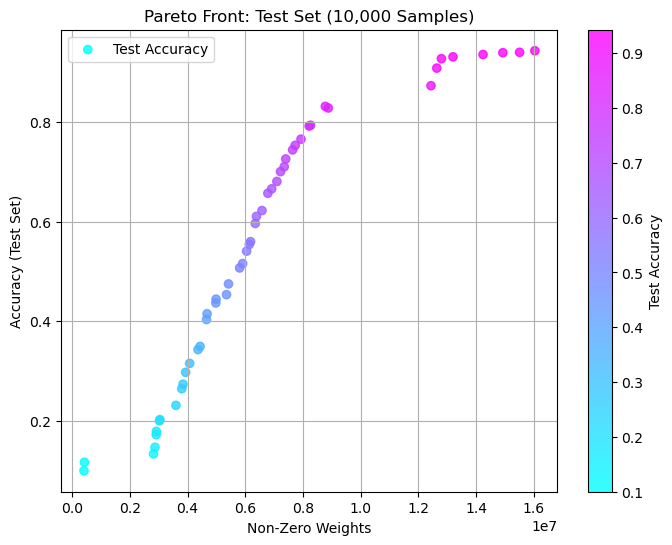

Test Pareto front plot saved at: resnet101_phase_1_saved_models\pareto_front_test.png


In [28]:
def plot_final_pareto_front_separately(result, optimization_accuracies, validation_accuracies, test_accuracies, non_zero_weights_list):
    if (len(optimization_accuracies) == 0) or (len(validation_accuracies) == 0) or (len(test_accuracies) == 0):
        print("Error: One of the accuracy lists is empty. Cannot plot Pareto fronts.")
        return None

    # =======================
    # Optimization set plot
    # =======================
    plt.figure(figsize=(8, 6))
    plt.scatter(non_zero_weights_list, optimization_accuracies, c=optimization_accuracies, cmap="cool", label="Optimization Accuracy", alpha=0.8)
    plt.colorbar(label="Optimization Accuracy")
    plt.xlabel("Non-Zero Weights")
    plt.ylabel("Accuracy (Optimization Set)")
    plt.title("Pareto Front: Optimization Set (500 Samples)")
    plt.grid(True)
    plt.legend()
    plot_path_opt = os.path.join(save_dir, "pareto_front_optimization.png")
    plt.savefig(plot_path_opt, dpi=300)
    plt.show()
    print(f"Optimization Pareto front plot saved at: {plot_path_opt}")

    # =======================
    # Validation set plot
    # =======================
    plt.figure(figsize=(8, 6))
    plt.scatter(non_zero_weights_list, validation_accuracies, c=validation_accuracies, cmap="cool", label="Validation Accuracy", alpha=0.8)
    plt.colorbar(label="Validation Accuracy")
    plt.xlabel("Non-Zero Weights")
    plt.ylabel("Accuracy (Validation Set)")
    plt.title("Pareto Front: Validation Set (2,000 Samples)")
    plt.grid(True)
    plt.legend()
    plot_path_val = os.path.join(save_dir, "pareto_front_validation.png")
    plt.savefig(plot_path_val, dpi=300)
    plt.show()
    print(f"Validation Pareto front plot saved at: {plot_path_val}")

    # =======================
    # Test set plot
    # =======================
    plt.figure(figsize=(8, 6))
    plt.scatter(non_zero_weights_list, test_accuracies, c=test_accuracies, cmap="cool", label="Test Accuracy", alpha=0.8)
    plt.colorbar(label="Test Accuracy")
    plt.xlabel("Non-Zero Weights")
    plt.ylabel("Accuracy (Test Set)")
    plt.title("Pareto Front: Test Set (10,000 Samples)")
    plt.grid(True)
    plt.legend()
    plot_path_test = os.path.join(save_dir, "pareto_front_test.png")
    plt.savefig(plot_path_test, dpi=300)
    plt.show()
    print(f"Test Pareto front plot saved at: {plot_path_test}")

plot_final_pareto_front_separately(
    result=result,
    optimization_accuracies=optimization_accuracies,
    validation_accuracies=validation_accuracies,
    test_accuracies=test_accuracies,
    non_zero_weights_list=non_zero_weights_list)

In [29]:
# Save NSGA-II result 
RESULT_CACHE_PATH = os.path.join(save_dir, "cached_nsga2_result_phase1.pkl")

with open(RESULT_CACHE_PATH, "wb") as f:
    pickle.dump(result, f)

print(f"Phase 1 NSGA-II results saved at: {RESULT_CACHE_PATH}")

Phase 1 NSGA-II results saved at: resnet101_phase_1_saved_models\cached_nsga2_result_phase1.pkl


In [30]:
# # Loading phase-1 nsga-2 results
# RESULT_CACHE_PATH = os.path.join("phase_1_saved_models", "cached_nsga2_result_phase1.pkl")

# try:
#     with open(RESULT_CACHE_PATH, "rb") as f:
#         result = pickle.load(f)
#     print(f"Successfully loaded NSGA-II result from {RESULT_CACHE_PATH}")
# except Exception as e:
#     print(f"Failed to load NSGA-II result: {e}")

In [31]:
csv_path = os.path.join(save_dir, "phase_1_optimization_results.csv")
solutions_data = []

if result:
    print(f"{'Solution':<10}{'Th1':<10}{'Th2':<10}{'Optimization Acc (%)':<20}{'Validation Acc (%)':<20}"
          f"{'Test Acc (%)':<15}{'#Non-Zero Weights':<20}")

    # Combine and sort by Test Accuracy (descending)
    combined = list(zip(
        result.pop.get("X"),            # (th1, th2)
        optimization_accuracies,        # optimization acc
        validation_accuracies,          # validation acc
        test_accuracies,                # test acc
        non_zero_weights_list           # non-zero weights
    ))
    combined.sort(key=lambda x: x[3], reverse=True)  # Sort by test_acc (index 3)

    # Loop through sorted results
    for i, ((th1, th2), opt_acc, val_acc, test_acc, non_zero_weights) in enumerate(combined):
        opt_acc_percentage = opt_acc * 100
        val_acc_percentage = val_acc * 100
        test_acc_percentage = test_acc * 100

        row = f"{i + 1:<10}{th1:<10.6f}{th2:<10.6f}{opt_acc_percentage:<20.2f}{val_acc_percentage:<20.2f}"
        row += f"{test_acc_percentage:<15.2f}{non_zero_weights:<20}"
        # print(row)

        solutions_data.append([i + 1, th1, th2, opt_acc_percentage, val_acc_percentage, test_acc_percentage, non_zero_weights])

    # Save to CSV
    df = pd.DataFrame(solutions_data, columns=[
        "Solution", "Th1", "Th2", "Optimization Acc (%)", "Validation Acc (%)", "Test Acc (%)", "#Non-Zero Weights"
    ])
    df.to_csv(csv_path, index=False)
    print(f"Optimization results saved at: {csv_path}")

else:
    print("Error: `result` is missing. Cannot print solutions.")

Solution  Th1       Th2       Optimization Acc (%)Validation Acc (%)  Test Acc (%)   #Non-Zero Weights   
Optimization results saved at: resnet101_phase_1_saved_models\phase_1_optimization_results.csv


---
## Phase 2 - Smart Pruning



In [31]:
# Get all available training indices
all_train_indices = set(range(len(train_dataset)))

# Combine indices used in Phase 1 (both 500-sample optimization and 2000-sample validation set)
used_indices = set(train_indices) | set(validation_indices)

# Get remaining indices that haven't been used
remaining_indices = list(all_train_indices - used_indices)

# Sample 500 new indices for Phase 2
train_indices_phase2 = random.sample(remaining_indices, 1000)

# Create a new training subset for Phase 2
train_subset_phase2 = Subset(train_dataset, train_indices_phase2)
train_loader_phase2 = DataLoader(train_subset_phase2, batch_size=32, shuffle=True, pin_memory=True)

print(f"New Training Subset for Phase 2 Size: {len(train_subset_phase2)}")

New Training Subset for Phase 2 Size: 500


### Choosing the best pruned model from Phase 1:

In [32]:
save_dir_2 = "resnet101_phase_2_saved_models"
os.makedirs(save_dir_2, exist_ok=True)

In [34]:
df['#Zero Weights'] = total_params_2 - df['#Non-Zero Weights']
df = df.sort_values(by="Test Acc (%)", ascending=False) # Sort DataFrame by Test Accuracy (highest accuracy first)
df.to_csv(os.path.join(save_dir_2, "phase_1_model_results.csv"), index=False)

df.head(20)

,Solution,Th1,Th2,Optimization Acc (%),Validation Acc (%),Test Acc (%),#Non-Zero Weights,#Zero Weights
0,1,-0.013615,0.013211,99.6,99.20,94.32,16038385,26482265
1,2,-0.014133,0.013421,99.2,98.95,94.00,15508591,27012059
2,3,-0.014437,0.013983,98.9,99.15,93.92,14929272,27591378
3,4,-0.015005,0.014439,98.6,98.85,93.56,14242109,28278541
4,5,-0.015845,0.015233,98.4,98.45,93.09,13201415,29319235
5,6,-0.016209,0.015519,97.9,98.00,92.73,12799560,29721090
6,7,-0.016110,0.015935,96.1,96.55,90.83,12639354,29881296
7,8,-0.016818,0.015463,92.9,93.85,87.29,12438411,30082239
8,9,-0.020143,0.019276,88.2,88.05,83.15,8775097,33745553
9,10,-0.019954,0.019252,88.3,87.80,82.82,8877807,33642843


In [35]:
# Sort by #Non-Zero Weights first (ensures closest match is picked correctly)
df = df.sort_values(by="#Non-Zero Weights", ascending=True)
target_weights = 12_799_560
closest_index = (df['#Non-Zero Weights'] - target_weights).abs().idxmin() # Find the row closest to targeted value

# Get the selected row
selected_row = df.loc[[closest_index]]  # Keep it as a DataFrame for easy saving
selected_row2 = df.loc[closest_index]
print(f"Selected Row for Phase 2:\n{selected_row2}")

selected_row_path = os.path.join(save_dir_2, "selected_row_phase2.csv")
selected_row.to_csv(selected_row_path, index=False)
print(f"Selected row saved at: {selected_row_path}")

Selected Row for Phase 2:
Solution                6.000000e+00
Th1                    -1.620936e-02
Th2                     1.551877e-02
Optimization Acc (%)    9.790000e+01
Validation Acc (%)      9.800000e+01
Test Acc (%)            9.273000e+01
#Non-Zero Weights       1.279956e+07
#Zero Weights           2.972109e+07
Name: 5, dtype: float64
Selected row saved at: resnet101_phase_2_saved_models\selected_row_phase2.csv


In [36]:
# Function to retrieve pruned model closest to target weights
def get_pruned_model_from_cached(selected_row, cached_models, non_zero_weights_list):
    
    if len(cached_models) == 0 or len(non_zero_weights_list) == 0:
        print("Error: Cached models or non-zero weights list is empty.")
        return None
    try:
        target_weights = selected_row["#Non-Zero Weights"].item()  # Extract target weight count
    except KeyError:
        print("Error: '#Non-Zero Weights' column missing in selected row.")
        return None

    # Find the model with closest matching non-zero weights
    closest_index = np.argmin(np.abs(np.array(non_zero_weights_list) - target_weights))

    # Retrieve the actual pruned model
    th1, th2, best_pruned_model = cached_models[closest_index]

    print(f"Retrieved pruned model with {non_zero_weights_list[closest_index]} non-zero weights.")

    return best_pruned_model

In [37]:
best_pruned_model = get_pruned_model_from_cached(selected_row, cached_models, non_zero_weights_list)

Retrieved pruned model with 12799560 non-zero weights.


In [38]:
# make a deep copy
pruned_model_copy = copy.deepcopy(best_pruned_model)

In [39]:
# saving model
model_save_path = os.path.join(save_dir_2, "pruned_resnet_model.pt")
torch.save(best_pruned_model.state_dict(), model_save_path)

print(f"Pruned model saved to: {model_save_path}")

Pruned model saved to: resnet101_phase_2_saved_models\pruned_resnet_model.pt


In [40]:
# load it (uncomment when needed) **this model i named dummy_model**

# # Load to same device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Rebuild the same model architecture
# dummy_model = models.resnet50(pretrained=True)
# dummy_model.fc = nn.Linear(dummy_model.fc.in_features, 10)  # Must match original modification
# dummy_model = dummy_model.to(device)

# # Load the saved weights
# model_save_path = os.path.join(save_dir_2, "pruned_resnet_model.pt")
# dummy_model.load_state_dict(torch.load(model_save_path, map_location=device))
# dummy_model.eval()

# print("✅ Pruned model loaded successfully.")

### Analyzing Chosen Pruned Model

In [41]:
print(pruned_model_copy)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
# Check the weights in specific layers
for name, param in pruned_model_copy.named_parameters():
    if param.requires_grad:
        non_zero = (param != 0).sum().item()
        print(f"layer: {name:<40} | Non-Zero Weights: {non_zero:,}")

layer: conv1.weight                             | Non-Zero Weights: 5,261
layer: bn1.weight                               | Non-Zero Weights: 49
layer: bn1.bias                                 | Non-Zero Weights: 49
layer: layer1.0.conv1.weight                    | Non-Zero Weights: 1,771
layer: layer1.0.bn1.weight                      | Non-Zero Weights: 51
layer: layer1.0.bn1.bias                        | Non-Zero Weights: 42
layer: layer1.0.conv2.weight                    | Non-Zero Weights: 14,329
layer: layer1.0.bn2.weight                      | Non-Zero Weights: 62
layer: layer1.0.bn2.bias                        | Non-Zero Weights: 59
layer: layer1.0.conv3.weight                    | Non-Zero Weights: 6,815
layer: layer1.0.bn3.weight                      | Non-Zero Weights: 174
layer: layer1.0.bn3.bias                        | Non-Zero Weights: 188
layer: layer1.0.downsample.0.weight             | Non-Zero Weights: 6,634
layer: layer1.0.downsample.1.weight             | Non-Zero 

In [43]:
from matplotlib.patches import Patch

layer_names = []
non_zero_counts = []
colors = []

layer_colors = {"layer1": "tab:blue","layer2": "tab:orange","layer3": "tab:green","layer4": "tab:red","default": "tab:gray"}

for name, module in pruned_model_copy.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        weight = module.weight.data
        non_zero = (weight != 0).sum().item()

        print(f"Conv2D Layer: {name:<40} | Non-Zero Weights: {non_zero:,}")
        layer_names.append(name)
        non_zero_counts.append(non_zero)

        if name.startswith("layer1"):
            colors.append(layer_colors["layer1"])
        elif name.startswith("layer2"):
            colors.append(layer_colors["layer2"])
        elif name.startswith("layer3"):
            colors.append(layer_colors["layer3"])
        elif name.startswith("layer4"):
            colors.append(layer_colors["layer4"])
        else:
            colors.append(layer_colors["default"])  # conv1 or other

df_layers = pd.DataFrame({
    "Layer Name": layer_names,
    "Non-Zero Weights": non_zero_counts,
    "Color": colors
})

csv_path = os.path.join(save_dir_2, "architecture_layer_and_weights_count.csv")
df_layers.to_csv(csv_path, index=False)

print(f"\nLayer-wise data saved to: {csv_path}")

Conv2D Layer: conv1                                    | Non-Zero Weights: 5,261
Conv2D Layer: layer1.0.conv1                           | Non-Zero Weights: 1,771
Conv2D Layer: layer1.0.conv2                           | Non-Zero Weights: 14,329
Conv2D Layer: layer1.0.conv3                           | Non-Zero Weights: 6,815
Conv2D Layer: layer1.0.downsample.0                    | Non-Zero Weights: 6,634
Conv2D Layer: layer1.1.conv1                           | Non-Zero Weights: 3,647
Conv2D Layer: layer1.1.conv2                           | Non-Zero Weights: 4,768
Conv2D Layer: layer1.1.conv3                           | Non-Zero Weights: 2,552
Conv2D Layer: layer1.2.conv1                           | Non-Zero Weights: 6,636
Conv2D Layer: layer1.2.conv2                           | Non-Zero Weights: 15,773
Conv2D Layer: layer1.2.conv3                           | Non-Zero Weights: 4,872
Conv2D Layer: layer2.0.conv1                           | Non-Zero Weights: 15,643
Conv2D Layer: layer2.0.co

#### Barplot for Pruned Model Weight Counts per Layer:

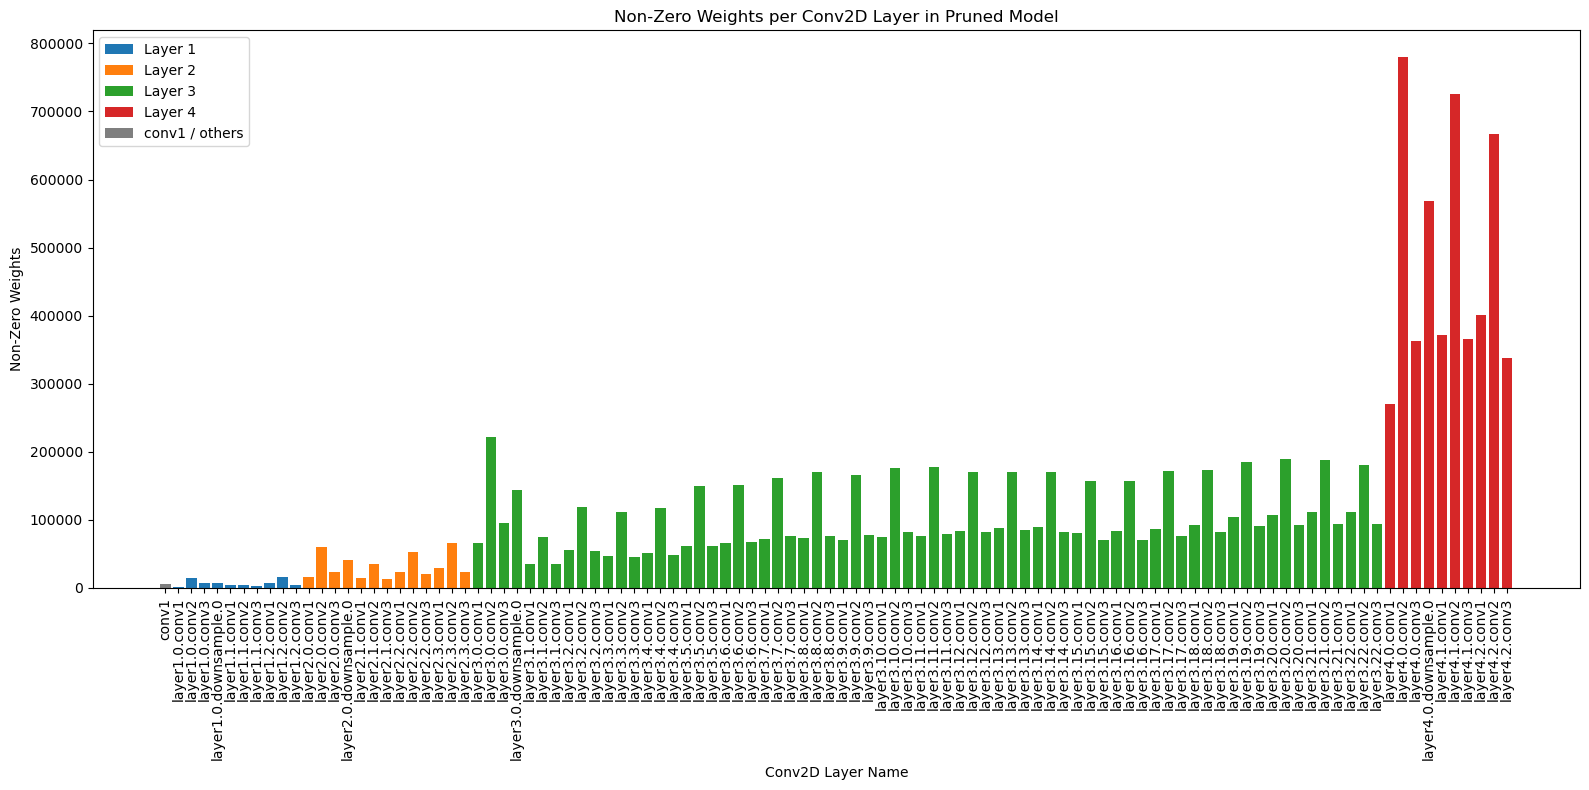

In [44]:
plt.figure(figsize=(16, 8))
plt.bar(layer_names, non_zero_counts, color=colors)
plt.xlabel('Conv2D Layer Name')
plt.ylabel('Non-Zero Weights')
plt.title('Non-Zero Weights per Conv2D Layer in Pruned Model')
plt.xticks(rotation=90)
plt.tight_layout()

legend_elements = [
    Patch(facecolor=layer_colors["layer1"], label="Layer 1"),
    Patch(facecolor=layer_colors["layer2"], label="Layer 2"),
    Patch(facecolor=layer_colors["layer3"], label="Layer 3"),
    Patch(facecolor=layer_colors["layer4"], label="Layer 4"),
    Patch(facecolor=layer_colors["default"], label="conv1 / others"),
]
plt.legend(handles=legend_elements, loc='upper left')
plt.savefig(os.path.join(save_dir_2, "architecture_layers_weights_barplot.png"), dpi=300)
plt.show()

In [45]:
from collections import OrderedDict
import torch.nn as nn

# Extract only internal Conv2d layers (not conv1, fc, classifier, etc.)
def extract_conv2d_layers(model):
    conv_layers = OrderedDict()

    def _recursive_extract(module, prefix=""):
        for name, submodule in module.named_children():
            layer_name = f"{prefix}.{name}" if prefix else name

            if isinstance(submodule, nn.Conv2d):
                if layer_name == "conv1":  # Skip top-level conv1 and any classifier/fc/output layers
                    continue
                if any(x in layer_name.lower() for x in ['classifier', 'fc', 'output']):
                    continue
                conv_layers[layer_name] = submodule
            else:
                _recursive_extract(submodule, layer_name)

    _recursive_extract(model)
    return conv_layers

conv_layers = extract_conv2d_layers(pruned_model_copy)

print(f"# of layers: {len(conv_layers)}\n")
for name, layer in conv_layers.items():
    print(f"{name}: {layer.weight.shape}")

# of layers: 103

layer1.0.conv1: torch.Size([64, 64, 1, 1])
layer1.0.conv2: torch.Size([64, 64, 3, 3])
layer1.0.conv3: torch.Size([256, 64, 1, 1])
layer1.0.downsample.0: torch.Size([256, 64, 1, 1])
layer1.1.conv1: torch.Size([64, 256, 1, 1])
layer1.1.conv2: torch.Size([64, 64, 3, 3])
layer1.1.conv3: torch.Size([256, 64, 1, 1])
layer1.2.conv1: torch.Size([64, 256, 1, 1])
layer1.2.conv2: torch.Size([64, 64, 3, 3])
layer1.2.conv3: torch.Size([256, 64, 1, 1])
layer2.0.conv1: torch.Size([128, 256, 1, 1])
layer2.0.conv2: torch.Size([128, 128, 3, 3])
layer2.0.conv3: torch.Size([512, 128, 1, 1])
layer2.0.downsample.0: torch.Size([512, 256, 1, 1])
layer2.1.conv1: torch.Size([128, 512, 1, 1])
layer2.1.conv2: torch.Size([128, 128, 3, 3])
layer2.1.conv3: torch.Size([512, 128, 1, 1])
layer2.2.conv1: torch.Size([128, 512, 1, 1])
layer2.2.conv2: torch.Size([128, 128, 3, 3])
layer2.2.conv3: torch.Size([512, 128, 1, 1])
layer2.3.conv1: torch.Size([128, 512, 1, 1])
layer2.3.conv2: torch.Size([128, 128,

---
#### Kernel Size Distribution (Bar Plot)

What it shows:
- How many Conv2D layers use 1x1, 3x3, etc.

Why it matters:
- 1×1 convolutions are mostly used for channel mixing or dimensionality reduction/expansion (e.g., ResNet bottlenecks).
    - Often redundant and pruning-friendly.
- 3×3 convolutions are used for spatial pattern detection (e.g., edges, textures).
    - Carry spatial information, but some may still be pruned if redundant.

Helps you identify how many layers are pruning-safe (e.g., 1x1 filters in conv1 and conv3 of bottlenecks).

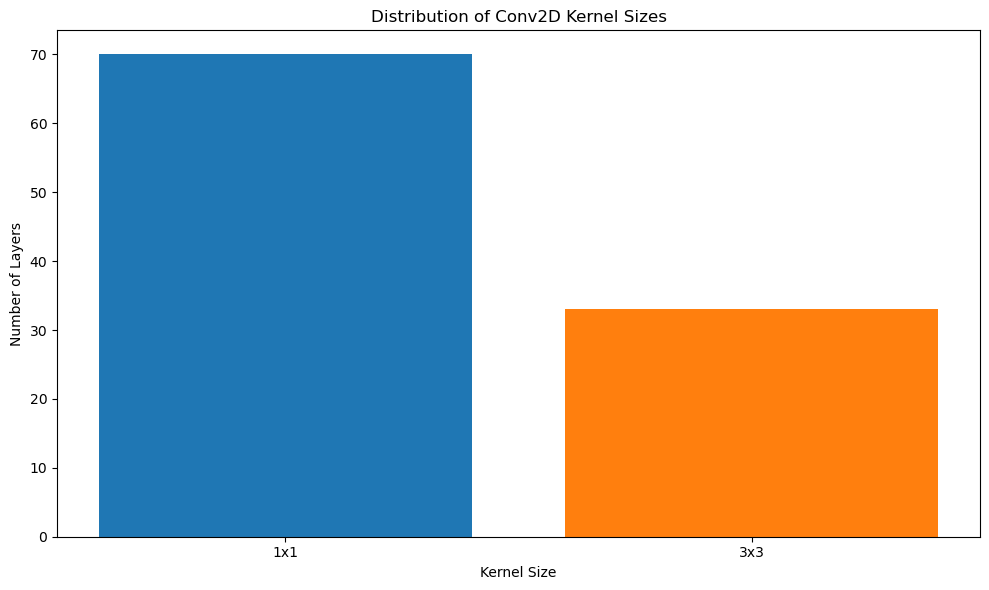

Kernel size distribution plot saved to: resnet101_phase_2_saved_models\conv_kernel_size_distribution.png


In [46]:
from collections import Counter

# Count kernel sizes
kernel_sizes = [tuple(layer.weight.shape[2:]) for layer in conv_layers.values()]
counter = Counter(kernel_sizes)

# Convert to strings and values
labels = [f"{k[0]}x{k[1]}" for k in counter.keys()]
values = list(counter.values())

# Assign a different color to each bar
colors = plt.cm.tab10.colors  # Use a colormap with distinct colors
bar_colors = [colors[i % len(colors)] for i in range(len(labels))]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=bar_colors)
plt.title("Distribution of Conv2D Kernel Sizes")
plt.xlabel("Kernel Size")
plt.ylabel("Number of Layers")
plt.tight_layout()

# Save the figure
kernel_plot_path = os.path.join(save_dir_2, "conv_kernel_size_distribution.png")
plt.savefig(kernel_plot_path, dpi=300)

plt.show()
print(f"Kernel size distribution plot saved to: {kernel_plot_path}")

---
#### Output Filters per Layer (Bar Chart)

What it shows:
- Number of output channels (filters) per Conv2D layer.
- Color-coded by layer group (layer1, layer2, etc.).

Why it matters:
- Layers with more output filters take up more parameters and computation.
- These are good pruning targets — especially in deeper layers (layer3, layer4).
- Helps prioritize where the biggest pruning gains (parameter-wise) could come from.

Key takeaway:
- Start pruning from deeper layers with lots of filters (like layer3.5.conv2, layer4.1.conv2, etc.) rather than early low-filter ones

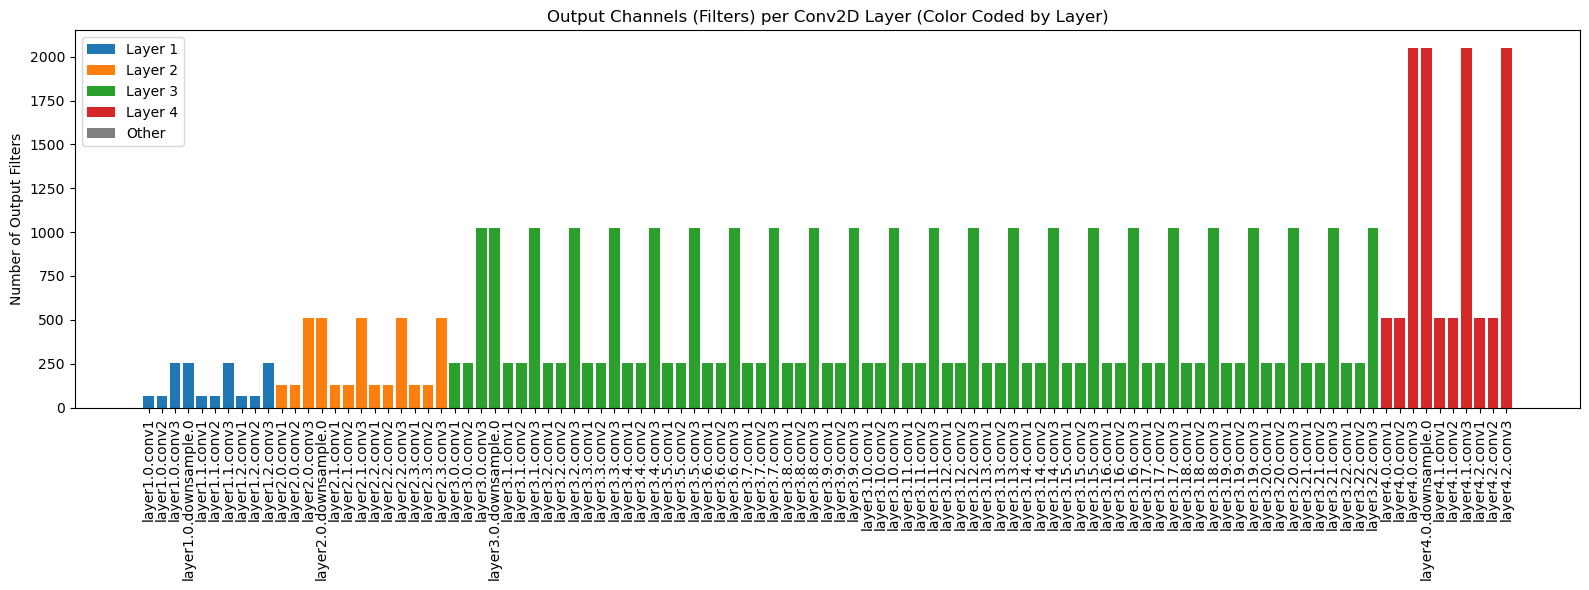

In [47]:
out_channels = [layer.weight.shape[0] for layer in conv_layers.values()]
layer_names = list(conv_layers.keys())

def get_layer_group(name):
    if name.startswith("layer1"):
        return "Layer 1"
    elif name.startswith("layer2"):
        return "Layer 2"
    elif name.startswith("layer3"):
        return "Layer 3"
    elif name.startswith("layer4"):
        return "Layer 4"
    else:
        return "Other"

group_colors = {"Layer 1": "tab:blue", "Layer 2": "tab:orange","Layer 3": "tab:green","Layer 4": "tab:red","Other": "tab:gray"}
bar_colors = [group_colors[get_layer_group(name)] for name in layer_names]

plt.figure(figsize=(16, 6))
plt.bar(layer_names, out_channels, color=bar_colors)
plt.xticks(rotation=90)
plt.ylabel("Number of Output Filters")
plt.title("Output Channels (Filters) per Conv2D Layer (Color Coded by Layer)")
plt.tight_layout()

legend_elements = [Patch(facecolor=color, label=label) for label, color in group_colors.items()]
plt.legend(handles=legend_elements, loc="upper left")

filter_plot_path = os.path.join(save_dir_2, "output_channels_per_layer.png")
plt.savefig(filter_plot_path, dpi=300)
plt.show()

---
#### Layer Shape Heatmap ([OUT, IN, H, W])

- A heatmap where each layer’s shape ([output channels, input channels, height, width]) is visualized as a colored block.
- Compact visual summary of layer complexity.
- Quickly shows:
    - Which layers are wide (high OUT/IN channels)
    - Which use small or large kernels (1×1 vs 3×3)

Helps spot anomalies, like:
- Super wide layers with low kernel size (e.g., 2048 × 1024 × 1 × 1) — great pruning targets
- Can Use to see redundancy in deep 1x1 layers and balance complexity across your model.

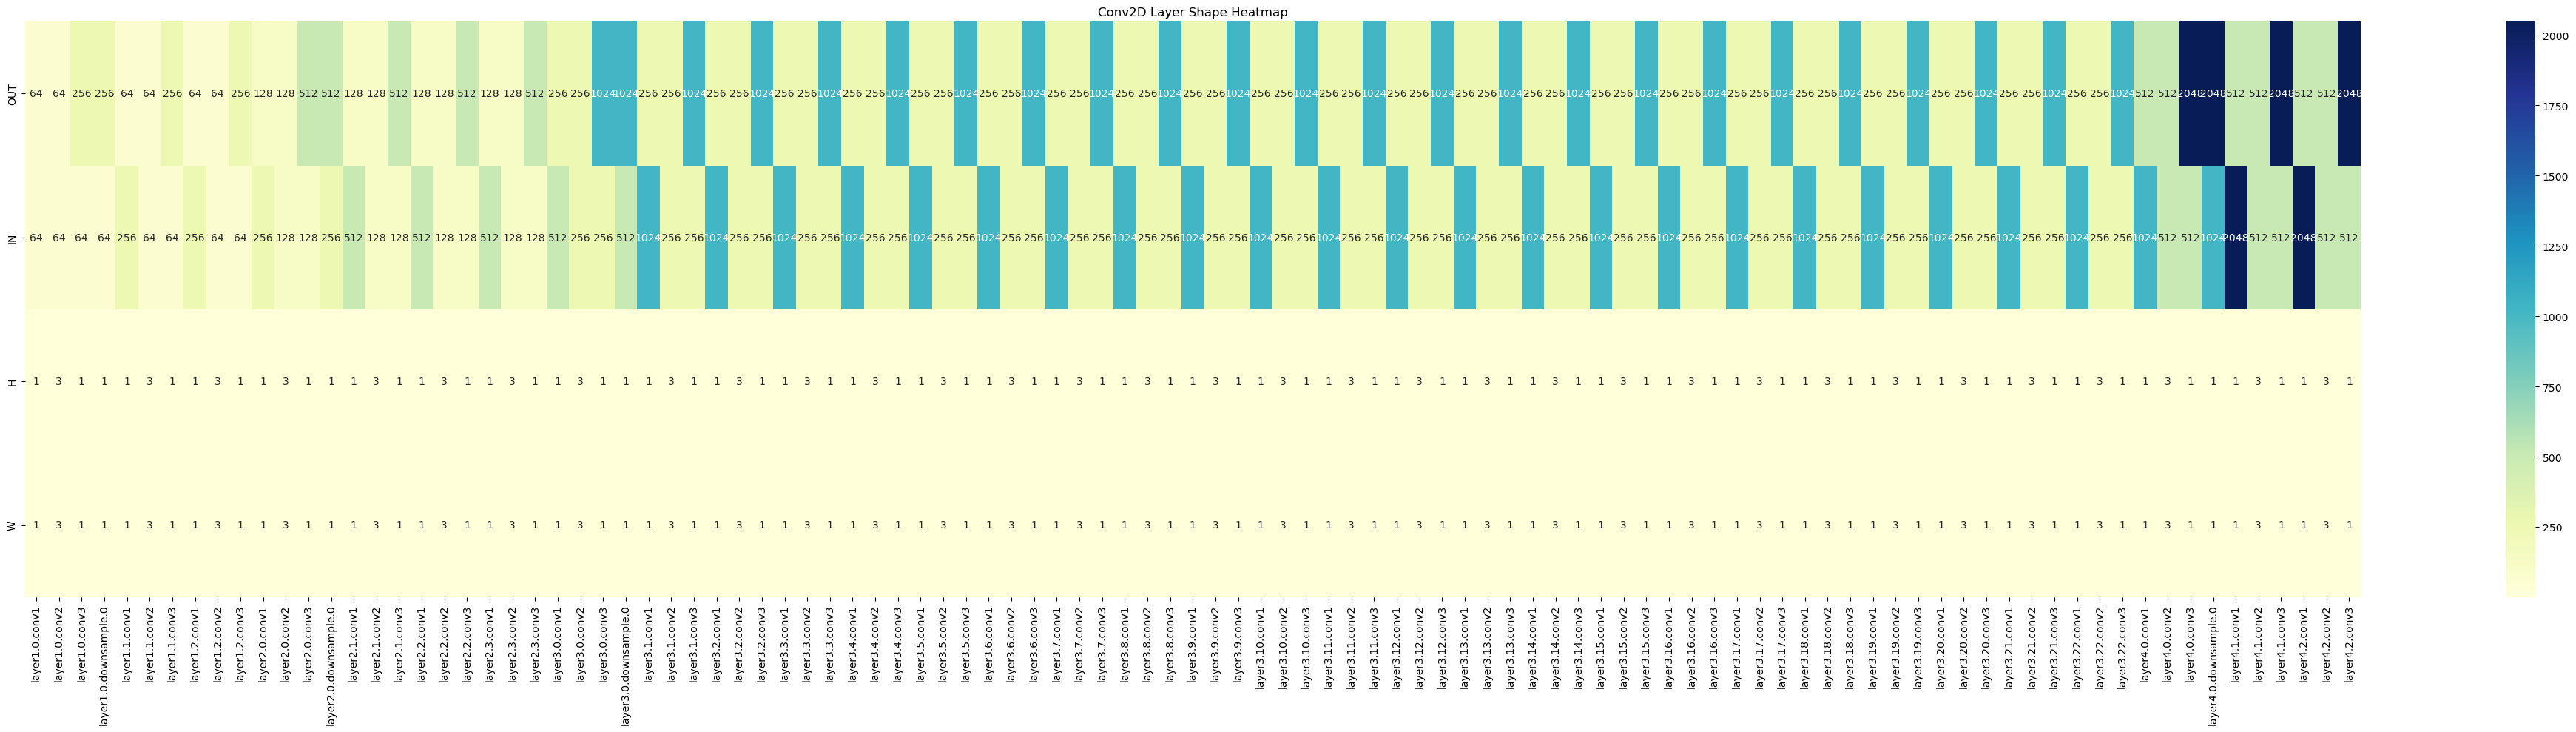

In [48]:
import seaborn as sns

# Extract shape matrix: [out, in, h, w] per layer
shapes = [list(layer.weight.shape) for layer in conv_layers.values()]
shape_matrix = np.array(shapes)

plt.figure(figsize=(40, 10))
sns.heatmap(
    shape_matrix.T,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    yticklabels=["OUT", "IN", "H", "W"]
)
plt.xticks(ticks=np.arange(len(conv_layers)) + 0.5, labels=layer_names, rotation=90)
plt.title("Conv2D Layer Shape Heatmap")
plt.tight_layout()

heatmap_path = os.path.join(save_dir_2, "conv2d_layer_shapes_heatmap.png")
plt.savefig(heatmap_path, dpi=300)

plt.show()

---
#### Sparsity per Layer (1 - non-zero ratio)

What it shows:
- How sparse each Conv2D layer is (i.e., how many weights are zero).
- High sparsity = lots of zeros → likely prunable.
- Low sparsity = all weights active → possibly important for accuracy.

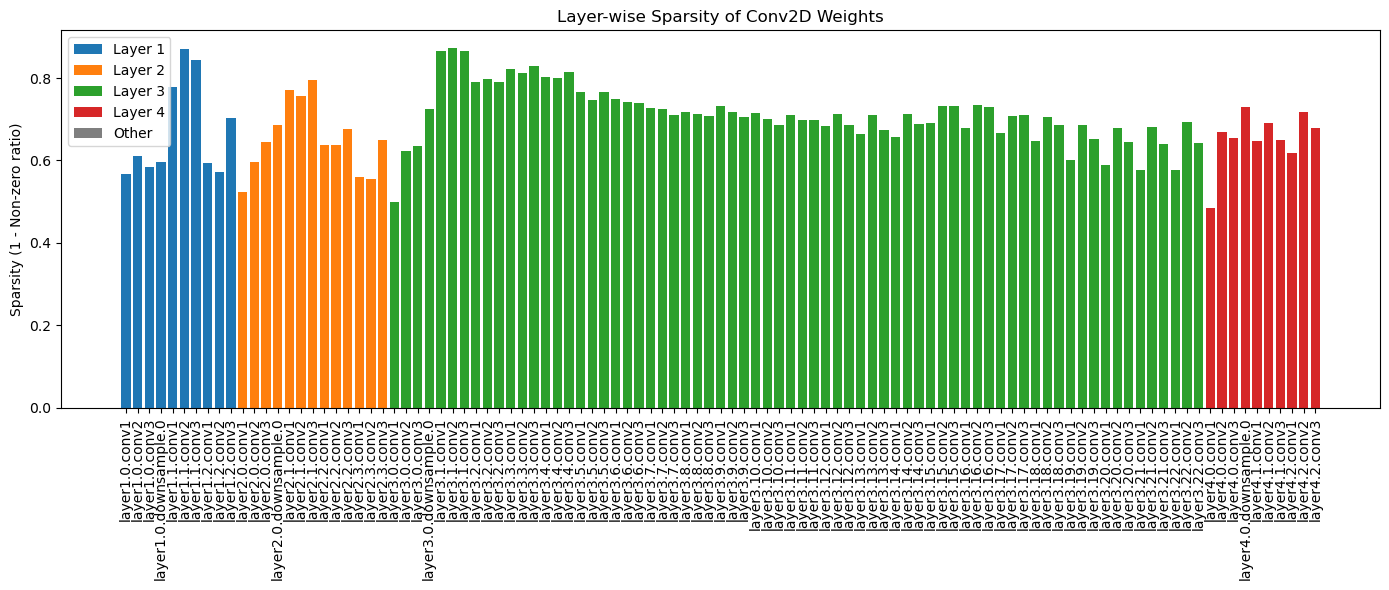

✅ Sparsity plot saved to: resnet101_phase_2_saved_models\layerwise_sparsity.png


In [49]:
sparsity = []
for layer in conv_layers.values():
    total = layer.weight.numel()
    non_zero = (layer.weight != 0).sum().item()
    sparsity.append(1 - non_zero / total)

def get_layer_group(name):
    if name.startswith("layer1"):
        return "Layer 1"
    elif name.startswith("layer2"):
        return "Layer 2"
    elif name.startswith("layer3"):
        return "Layer 3"
    elif name.startswith("layer4"):
        return "Layer 4"
    else:
        return "Other"

group_colors = {
    "Layer 1": "tab:blue",
    "Layer 2": "tab:orange",
    "Layer 3": "tab:green",
    "Layer 4": "tab:red",
    "Other": "tab:gray"
}

# Assign colors based on layer group
bar_colors = [group_colors[get_layer_group(name)] for name in layer_names]

plt.figure(figsize=(14, 6))
plt.bar(layer_names, sparsity, color=bar_colors)
plt.xticks(rotation=90)
plt.ylabel("Sparsity (1 - Non-zero ratio)")
plt.title("Layer-wise Sparsity of Conv2D Weights")
plt.tight_layout()

legend_elements = [Patch(facecolor=color, label=label) for label, color in group_colors.items()]
plt.legend(handles=legend_elements, loc="upper left")

sparsity_plot_path = os.path.join(save_dir_2, "layerwise_sparsity.png")
plt.savefig(sparsity_plot_path, dpi=300)

plt.show()
print(f"✅ Sparsity plot saved to: {sparsity_plot_path}")

In [50]:
def calculate_layer_sparsity(conv_layers):
    layer_sparsity = {}
    for name, layer in conv_layers.items():
        weight = layer.weight.data
        total_params = weight.numel()
        non_zero_params = (weight != 0).sum().item()
        sparsity = 1 - (non_zero_params / total_params)
        layer_sparsity[name] = sparsity
    return layer_sparsity

sparsity_dict = calculate_layer_sparsity(conv_layers)

for name, sparsity in sparsity_dict.items():
    print(f"{name}: {sparsity:.4f}")

df_sparsity = pd.DataFrame(list(sparsity_dict.items()), columns=["Layer Name", "Sparsity"])
sparsity_table_path = os.path.join(save_dir_2, "layerwise_sparsity_table.csv")
df_sparsity.to_csv(sparsity_table_path, index=False)

print(f"\n✅ Sparsity table saved to: {sparsity_table_path}")

layer1.0.conv1: 0.5676
layer1.0.conv2: 0.6113
layer1.0.conv3: 0.5840
layer1.0.downsample.0: 0.5951
layer1.1.conv1: 0.7774
layer1.1.conv2: 0.8707
layer1.1.conv3: 0.8442
layer1.2.conv1: 0.5950
layer1.2.conv2: 0.5721
layer1.2.conv3: 0.7026
layer2.0.conv1: 0.5226
layer2.0.conv2: 0.5964
layer2.0.conv3: 0.6447
layer2.0.downsample.0: 0.6867
layer2.1.conv1: 0.7700
layer2.1.conv2: 0.7577
layer2.1.conv3: 0.7946
layer2.2.conv1: 0.6364
layer2.2.conv2: 0.6374
layer2.2.conv3: 0.6776
layer2.3.conv1: 0.5610
layer2.3.conv2: 0.5538
layer2.3.conv3: 0.6491
layer3.0.conv1: 0.5002
layer3.0.conv2: 0.6240
layer3.0.conv3: 0.6358
layer3.0.downsample.0: 0.7252
layer3.1.conv1: 0.8649
layer3.1.conv2: 0.8724
layer3.1.conv3: 0.8653
layer3.2.conv1: 0.7895
layer3.2.conv2: 0.7974
layer3.2.conv3: 0.7916
layer3.3.conv1: 0.8232
layer3.3.conv2: 0.8115
layer3.3.conv3: 0.8283
layer3.4.conv1: 0.8023
layer3.4.conv2: 0.8010
layer3.4.conv3: 0.8154
layer3.5.conv1: 0.7659
layer3.5.conv2: 0.7459
layer3.5.conv3: 0.7672
layer3.6.conv

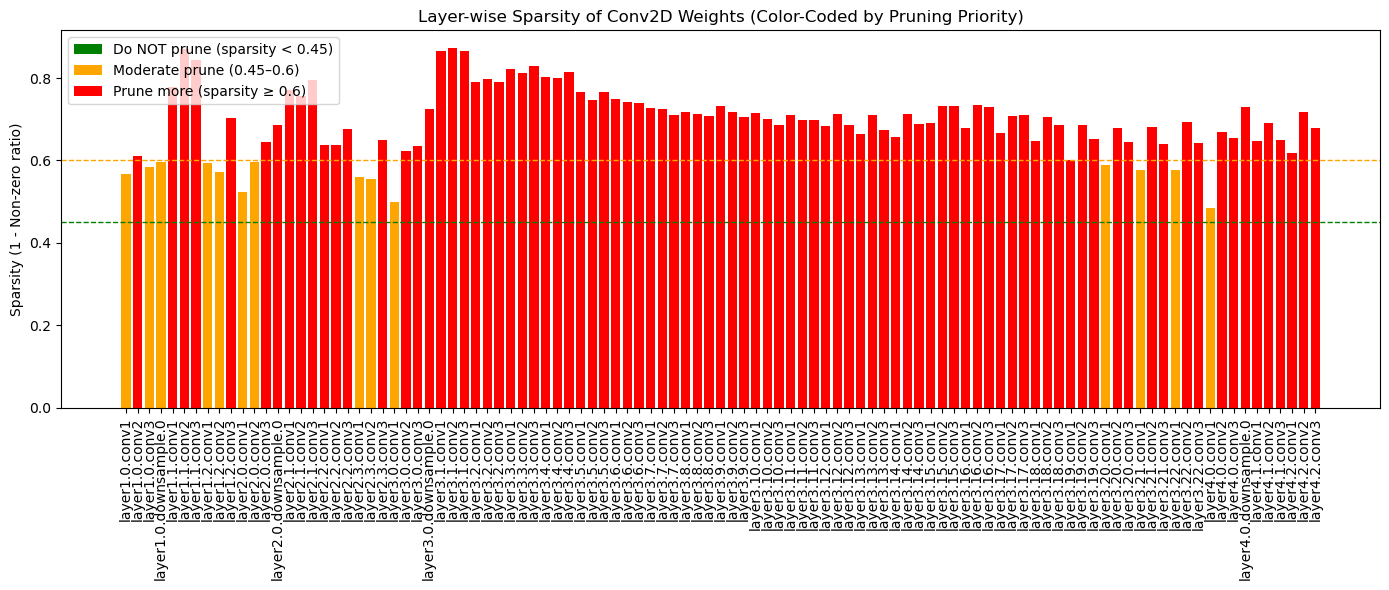

✅ Sparsity plot saved to: resnet101_phase_2_saved_models\layerwise_sparsity_cutoff.png


In [51]:
sparsity = []
for layer in conv_layers.values():
    total = layer.weight.numel()
    non_zero = (layer.weight != 0).sum().item()
    sparsity.append(1 - non_zero / total)

bar_colors = []
for s in sparsity:
    if s < 0.45:
        bar_colors.append("green")   # Do NOT prune
    elif s < 0.6:
        bar_colors.append("orange")  # Moderate prune
    else:
        bar_colors.append("red")     # Heavily pruned

plt.figure(figsize=(14, 6))
plt.bar(layer_names, sparsity, color=bar_colors)
plt.xticks(rotation=90)
plt.ylabel("Sparsity (1 - Non-zero ratio)")
plt.title("Layer-wise Sparsity of Conv2D Weights (Color-Coded by Pruning Priority)")
plt.axhline(0.45, color="green", linestyle="--", linewidth=1)
plt.axhline(0.6, color="orange", linestyle="--", linewidth=1)
plt.tight_layout()

legend_elements = [
    Patch(facecolor="green", label="Do NOT prune (sparsity < 0.45)"),
    Patch(facecolor="orange", label="Moderate prune (0.45–0.6)"),
    Patch(facecolor="red", label="Prune more (sparsity ≥ 0.6)")
]
plt.legend(handles=legend_elements, loc="upper left")

sparsity_plot_path = os.path.join(save_dir_2, "layerwise_sparsity_cutoff.png")
plt.savefig(sparsity_plot_path, dpi=300)
plt.show()
print(f"✅ Sparsity plot saved to: {sparsity_plot_path}")

In [52]:
def generate_layer_metadata(model):
    from collections import OrderedDict
    import torch.nn as nn

    conv_layers = OrderedDict()

    def _recursive_extract(module, prefix=""):
        for name, submodule in module.named_children():
            layer_name = f"{prefix}.{name}" if prefix else name

            if isinstance(submodule, nn.Conv2d):
                if layer_name == "conv1":  # Skip input conv
                    continue
                if any(x in layer_name.lower() for x in ['classifier', 'fc', 'output']):
                    continue
                conv_layers[layer_name] = submodule
            else:
                _recursive_extract(submodule, layer_name)

    _recursive_extract(model)

    layer_metadata = []

    for name, layer in conv_layers.items():
        weight = layer.weight.data
        total_params = weight.numel()
        non_zero_params = (weight != 0).sum().item()
        sparsity = 1 - (non_zero_params / total_params)

        kernel_size = tuple(weight.shape[2:])     # (H, W)
        out_channels = weight.shape[0]            # Number of output filters

        if name.startswith("layer1"):
            group = "layer1"
        elif name.startswith("layer2"):
            group = "layer2"
        elif name.startswith("layer3"):
            group = "layer3"
        elif name.startswith("layer4"):
            group = "layer4"
        else:
            group = "other"

        layer_metadata.append((
            name, total_params, non_zero_params, sparsity, group, kernel_size, out_channels, layer
        ))

    return layer_metadata


In [53]:
layer_metadata = generate_layer_metadata(pruned_model_copy)

for name, total, nonzero, sparsity, group, ksize, out_ch, _ in layer_metadata:
    print(f"{name:30s} | Weights: {nonzero:8,d}/{total:8,d} | Sparsity: {sparsity:.3f} | Kernel: {ksize} | Out: {out_ch:4d} | Group: {group}")


layer1.0.conv1                 | Weights:    1,771/   4,096 | Sparsity: 0.568 | Kernel: (1, 1) | Out:   64 | Group: layer1
layer1.0.conv2                 | Weights:   14,329/  36,864 | Sparsity: 0.611 | Kernel: (3, 3) | Out:   64 | Group: layer1
layer1.0.conv3                 | Weights:    6,815/  16,384 | Sparsity: 0.584 | Kernel: (1, 1) | Out:  256 | Group: layer1
layer1.0.downsample.0          | Weights:    6,634/  16,384 | Sparsity: 0.595 | Kernel: (1, 1) | Out:  256 | Group: layer1
layer1.1.conv1                 | Weights:    3,647/  16,384 | Sparsity: 0.777 | Kernel: (1, 1) | Out:   64 | Group: layer1
layer1.1.conv2                 | Weights:    4,768/  36,864 | Sparsity: 0.871 | Kernel: (3, 3) | Out:   64 | Group: layer1
layer1.1.conv3                 | Weights:    2,552/  16,384 | Sparsity: 0.844 | Kernel: (1, 1) | Out:  256 | Group: layer1
layer1.2.conv1                 | Weights:    6,636/  16,384 | Sparsity: 0.595 | Kernel: (1, 1) | Out:   64 | Group: layer1
layer1.2.conv2  

In [54]:
# Convert to DataFrame
df_layer_metadata = pd.DataFrame([
    {
        "Layer Name": name,
        "Total Weights": total,
        "Non-Zero Weights": nonzero,
        "Sparsity": sparsity,
        "Group": group,
        "Kernel Size": f"{ksize[0]}x{ksize[1]}",
        "Output Filters": out_channels
    }
    for name, total, nonzero, sparsity, group, ksize, out_channels, _ in layer_metadata
])

# Save to CSV
metadata_save_path = os.path.join(save_dir_2, "phase2_layer_metadata.csv")
df_layer_metadata.to_csv(metadata_save_path, index=False)

print(f"✅ Layer metadata saved to: {metadata_save_path}")

✅ Layer metadata saved to: resnet101_phase_2_saved_models\phase2_layer_metadata.csv


#### Smart Sampling
Layer1 & Layer2: always rᵢ = 0.0

If sparsity < 0.45: also rᵢ = 0.0

Layer3 & Layer4: smartly biased within [0.03–0.06] or [0.06–0.15] based on:

how sparse the layer already is

how many weights it has

In [55]:
 """
    Compute importance scores for all Conv2d layers using the selected heuristic.

    Args:
        model (nn.Module)
        dataloader (DataLoader)
        criterion (int): 0 = L1, 1 = APoZ, 2 = Taylor

    Returns:
        dict: {layer_name: importance_scores}
    """
def compute_l1_importance(model):
    conv_layers = extract_conv2d_layers(model)
    importance_scores = {}

    for name, layer in conv_layers.items():
        with torch.no_grad():
            # L1 importance: sum over in_channels, height, width
            scores = layer.weight.abs().sum(dim=(1, 2, 3))  # shape: [out_channels]
        importance_scores[name] = scores.cpu().numpy()

    return importance_scores


# Activation 
def compute_apoz_importance(model, dataloader):
    model.eval()
    conv_layers = extract_conv2d_layers(model)
    apoz_scores = {name: np.zeros(layer.weight.shape[0]) for name, layer in conv_layers.items()}
    counts = {name: 0 for name in conv_layers}

    def register_hooks():
        handles = []
        for name, layer in conv_layers.items():
            def hook(module, input, output, name=name):
                if output is None: return
                zeros = (output == 0).float().sum(dim=(2, 3))  # shape: [B, C]
                total = output[0].numel() / output.shape[1]
                apoz_scores[name] += zeros.sum(dim=0).cpu().numpy() / total
                counts[name] += output.shape[0]
            handles.append(layer.register_forward_hook(hook))
        return handles

    handles = register_hooks()
    with torch.no_grad():
        for x, _ in dataloader:
            model(x.to(device))

    for h in handles:
        h.remove()

    # Normalize
    for name in apoz_scores:
        if counts[name] > 0:
            apoz_scores[name] /= counts[name]
        else:
            apoz_scores[name] = np.zeros_like(apoz_scores[name])

    return apoz_scores   


# Gradient-based
def compute_taylor_importance(model, dataloader, loss_fn):
    model.eval()
    conv_layers = extract_conv2d_layers(model)
    importance_scores = {name: np.zeros(layer.weight.shape[0]) for name, layer in conv_layers.items()}
    counts = {name: 0 for name in conv_layers}

    for name, layer in conv_layers.items():
        layer.weight.requires_grad = True

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()

        for name, layer in conv_layers.items():
            if layer.weight.grad is None:
                continue

            grad = layer.weight.grad.data  # [out_ch, in_ch, k, k]
            weight = layer.weight.data
            taylor_score = (weight * grad).abs().sum(dim=(1, 2, 3))  # shape: [out_ch]
            importance_scores[name] += taylor_score.cpu().numpy()
            counts[name] += 1

    for name in importance_scores:
        if counts[name] > 0:
            importance_scores[name] /= counts[name]

    return importance_scores

In [56]:
# Importance Score Function to Include All Heuristics
def get_importance_scores(model, dataloader, criterion):
    if criterion == 0:
        return compute_l1_importance(model)
    elif criterion == 1:
        return compute_apoz_importance(model, dataloader)
    elif criterion == 2:
        return compute_taylor_importance(model, dataloader, torch.nn.CrossEntropyLoss())
    else:
        raise ValueError("Invalid criterion index. Must be 0 (L1), 1 (APoZ), or 2 (Taylor).")

In [57]:

def extract_conv2d_layers(model):
    conv_layers = OrderedDict()

    def _recursive_extract(module, prefix=""):
        for name, submodule in module.named_children():
            layer_name = f"{prefix}.{name}" if prefix else name

            if isinstance(submodule, nn.Conv2d):
                if layer_name == "conv1":
                    continue
                if any(x in layer_name.lower() for x in ['classifier', 'fc', 'output']):
                    continue
                conv_layers[layer_name] = submodule
            else:
                _recursive_extract(submodule, layer_name)

    _recursive_extract(model)
    return conv_layers

In [62]:
metadata_csv = os.path.join(save_dir_2, "phase2_layer_metadata.csv")
df_metadata = pd.read_csv(metadata_csv)

# --- Extract required fields ---
layer_metadata = []
for _, row in df_metadata.iterrows():
    layer_metadata.append({
        "name": row["Layer Name"],
        "sparsity": float(row["Sparsity"]),
        "group": row["Group"],
        "total_weights": int(row["Total Weights"])
    })

# --- Smart Sampling ---
class SmartPruningSampler(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        pop = []
        for _ in range(n_samples):
            individual = []
            for meta in layer_metadata:
                name = meta.get("name", "")  # Layer name like 'layer3.0.downsample.0'
                group = meta["group"]
                sparsity = meta["sparsity"]
                total_weights = meta["total_weights"]

                # Default pruning ratio
                r = 0.0

                # Force no pruning for downsample layers
                if "downsample" in name:
                    r = 0.0
                elif group in {"layer1", "layer2"} or sparsity < 0.45:
                    r = 0.0
                elif group == "layer3":
                    r_range = np.linspace(0.01, 0.03, 4)
                    prob = sparsity * (total_weights / 1e5)
                    r = np.random.choice(r_range, p=self._bias_prob(r_range, prob))
                elif group == "layer4":
                    r_range = np.linspace(0.03, 0.10, 7)
                    prob = sparsity * (total_weights / 1e5)
                    r = np.random.choice(r_range, p=self._bias_prob(r_range, prob))

                # Sample compression type index
                # c = np.random.choice([0, 1, 2])
                c = np.random.choice([0]) # l1 mag only
                
                individual.extend([round(r, 3), c])
            pop.append(individual)
        return np.array(pop, dtype=np.float64)

    def _bias_prob(self, r_range, factor):
        factor = np.clip(factor, 0, 1)
        weights = np.linspace(1, 2, len(r_range)) ** (2 * factor)
        weights /= weights.sum()
        return weights


In [63]:
def generate_masks_from_individual(model, dataloader, individual, conv_layer_names):
    """
    Given a pruning genome [(r1, c1), ..., (rL, cL)], generate filter masks for all layers.

    Args:
        model: pruned_model from Phase 1
        dataloader: used if heuristic requires activations or gradients
        individual: list of (rᵢ, cᵢ) tuples, one per Conv2d layer
        conv_layer_names: ordered list of Conv2d layer names

    Returns:
        filter_masks: dict {layer_name: binary_mask}
    """
    filter_masks = {}

    for (layer_name, (ri, ci)) in zip(conv_layer_names, individual):
        scores = get_importance_scores(model, dataloader, ci)[layer_name]
        num_filters = len(scores)
        num_pruned = int(ri * num_filters)

        sorted_indices = np.argsort(scores)
        prune_indices = sorted_indices[:num_pruned]

        mask = np.ones(num_filters, dtype=np.uint8)
        mask[prune_indices] = 0
        filter_masks[layer_name] = mask

    return filter_masks

In [64]:
def apply_filter_masks(base_model, filter_masks):
    """
    Applies binary pruning masks to a copy of the base model.
    
    Args:
        base_model (nn.Module): The model to copy and prune.
        filter_masks (dict): {layer_name: binary_mask} from generate_masks()

    Returns:
        pruned_model (nn.Module): A deep-copied, masked version of base_model
    """
    pruned_model = deepcopy(base_model)
    conv_layers = extract_conv2d_layers(pruned_model)

    for layer_name, mask in filter_masks.items():
        layer = conv_layers[layer_name]

        with torch.no_grad():
            weight = layer.weight.data  # shape: [out_channels, in_channels, kH, kW]
            for i, keep in enumerate(mask):
                if keep == 0:
                    weight[i] = 0.0  # Zero out the entire filter

            # If the layer has bias, prune those too
            if layer.bias is not None:
                bias = layer.bias.data
                for i, keep in enumerate(mask):
                    if keep == 0:
                        bias[i] = 0.0

    return pruned_model

In [65]:
def evaluate_pruned_model(pruned_model, dataloader):
    """
    Evaluate model accuracy and count non-zero weights.

    Args:
        pruned_model (nn.Module): Masked model
        dataloader (DataLoader): Phase 2 data (500-sample subset)

    Returns:
        accuracy (float), non_zero_weights (int)
    """
    pruned_model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pruned_model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    non_zero_weights = sum((p != 0).sum().item() for p in pruned_model.parameters())

    return accuracy, non_zero_weights

In [66]:
class PhaseTwoPruningProblem(Problem):
    def __init__(self, base_model, dataloader, conv_layer_names):
        self.base_model = base_model
        self.dataloader = dataloader
        self.layer_names = conv_layer_names
        self.num_layers = len(conv_layer_names)
        self.initial_population = None
        self.txt_log_lines = []

        super().__init__(
            n_var=self.num_layers * 2,
            n_obj=2,
            n_constr=0,
            xl=np.array([0.0 if i % 2 == 0 else 0 for i in range(self.num_layers * 2)]),
            xu=np.array([0.15 if i % 2 == 0 else 2 for i in range(self.num_layers * 2)]),
            type_var=np.double
        )

    def _evaluate(self, X, out, *args, **kwargs):
        if self.initial_population is None:
            self.initial_population = X.copy()
            np.save(os.path.join(save_dir_2, "initial_population.npy"), self.initial_population)

        F = []

        for idx, individual in enumerate(X):
            parsed = [(round(float(individual[i]), 3), int(individual[i + 1])) for i in range(0, len(individual), 2)]

            try:
                filter_masks = generate_masks_from_individual(
                    self.base_model, self.dataloader, parsed, self.layer_names
                )
                masked_model = apply_filter_masks(self.base_model, filter_masks)
                acc, non_zero = evaluate_pruned_model(masked_model, self.dataloader)

                log_str = (
                    f"Individual {idx}\n"
                    f"Genome: {parsed}\n"
                    f"Accuracy: {acc:.4f}\n"
                    f"Non-Zero Weights: {non_zero}\n"
                    f"{'-'*40}"
                )
                self.txt_log_lines.append(log_str)
                print(log_str)

                F.append([non_zero, 1 - acc])

            except Exception as e:
                error_log = f"❌ [ERROR] Individual {idx} failed: {e}\n{'-'*40}"
                self.txt_log_lines.append(error_log)
                print(error_log)
                F.append([1e6, 1.0])  # Penalize failed individuals

        out["F"] = np.array(F)


In [67]:
def run_phase2_nsga2(base_model, train_loader_phase2):
    # Load conv layer names from metadata CSV
    metadata_df = pd.read_csv(os.path.join(save_dir_2, "phase2_layer_metadata.csv"))
    conv_layer_names = metadata_df["Layer Name"].tolist()

    problem = PhaseTwoPruningProblem(
        base_model=base_model,
        dataloader=train_loader_phase2,
        conv_layer_names=conv_layer_names
    )

    algorithm = NSGA2(
        pop_size=50,
        sampling=SmartPruningSampler(),  # Replace with RandomPruningSampler() if needed
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20, prob=1.0 / problem.n_var),
        eliminate_duplicates=True
    )

    result = minimize(
        problem,
        algorithm,
        termination=("n_gen", 50),
        seed=42,
        save_history=True,
        verbose=True
    )

    np.save(os.path.join(save_dir_2, "final_population.npy"), result.pop.get("X"))
    with open(os.path.join(save_dir_2, "phase_2_results.txt"), "w") as f:
        f.write("\n".join(problem.txt_log_lines))

    print("✅ Phase 2 NSGA-II complete. Results saved.")
    return result



In [68]:
# Load metadata CSV
metadata_df = pd.read_csv(os.path.join(save_dir_2, "phase2_layer_metadata.csv"))

# Extract layer names
conv_layer_names = metadata_df["Layer Name"].tolist()

# (Optional) Print for verification
print(f"Conv2D layers for Phase 2: {conv_layer_names}")

Conv2D layers for Phase 2: ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.0.downsample.0', 'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3', 'layer2.0.downsample.0', 'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1', 'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3', 'layer3.0.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3', 'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3', 'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3', 'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3', 'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3', 'layer3.6.conv1', 'layer3.6.conv2', 'layer3.6.conv3', 'layer3.7.conv1', 'layer3.7.conv2', 'layer3.7.conv3', 'layer3.8.conv1', 'layer3.8.conv2', 'layer3.8.conv3', 'layer3.9.conv1', 'layer3.9.conv2

In [69]:
# run_phase2_nsga2(pruned_model_copy, train_loader_phase2) # do not run (test fn)

In [70]:
F = result.F  # Objective values
X = result.X  # Corresponding decision vectors

# Convert error to accuracy
non_zero_weights = F[:, 0]
accuracies = 1 - F[:, 1]

# Print all 22 individuals
print("📊 Final Pareto Front (22 individuals):")
for i, (acc, nz) in enumerate(zip(accuracies, non_zero_weights)):
    print(f"[{i:02d}] Accuracy: {acc:.4f} | Non-Zero Weights: {int(nz)}")

📊 Final Pareto Front (22 individuals):
[00] Accuracy: 0.1030 | Non-Zero Weights: 409393
[01] Accuracy: 0.9960 | Non-Zero Weights: 16038385
[02] Accuracy: 0.9290 | Non-Zero Weights: 12438411
[03] Accuracy: 0.8830 | Non-Zero Weights: 8877807
[04] Accuracy: 0.1280 | Non-Zero Weights: 426094
[05] Accuracy: 0.1340 | Non-Zero Weights: 2820532
[06] Accuracy: 0.9860 | Non-Zero Weights: 14242109
[07] Accuracy: 0.2230 | Non-Zero Weights: 3597751
[08] Accuracy: 0.9840 | Non-Zero Weights: 13201415
[09] Accuracy: 0.8420 | Non-Zero Weights: 8265493
[10] Accuracy: 0.9890 | Non-Zero Weights: 14929272
[11] Accuracy: 0.8820 | Non-Zero Weights: 8775097
[12] Accuracy: 0.4860 | Non-Zero Weights: 5419210
[13] Accuracy: 0.8060 | Non-Zero Weights: 7933182
[14] Accuracy: 0.2640 | Non-Zero Weights: 3800462
[15] Accuracy: 0.3590 | Non-Zero Weights: 4433830
[16] Accuracy: 0.4070 | Non-Zero Weights: 4658012
[17] Accuracy: 0.9610 | Non-Zero Weights: 12639354
[18] Accuracy: 0.3280 | Non-Zero Weights: 4072228
[19] Ac

In [ ]:
result_phase2 = run_phase2_nsga2(pruned_model_copy, train_loader_subset)

Individual 0
Genome: [(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.023, 0), (0.03, 0), (0.03, 0), (0.0, 0), (0.03, 0), (0.017, 0), (0.017, 0), (0.01, 0), (0.03, 0), (0.03, 0), (0.03, 0), (0.01, 0), (0.03, 0), (0.03, 0), (0.017, 0), (0.017, 0), (0.017, 0), (0.023, 0), (0.023, 0), (0.023, 0), (0.023, 0), (0.03, 0), (0.017, 0), (0.023, 0), (0.023, 0), (0.023, 0), (0.03, 0), (0.017, 0), (0.023, 0), (0.03, 0), (0.01, 0), (0.03, 0), (0.017, 0), (0.01, 0), (0.03, 0), (0.03, 0), (0.03, 0), (0.023, 0), (0.01, 0), (0.03, 0), (0.023, 0), (0.017, 0), (0.023, 0), (0.01, 0), (0.03, 0), (0.017, 0), (0.03, 0), (0.023, 0), (0.023, 0), (0.023, 0), (0.017, 0), (0.03, 0), (0.03, 0), (0.03, 0), (0.03, 0), (0.03, 0), (0.03, 0), (0.01, 0), (0.017, 0), (0.01, 0), (0.023, 0), (0.023, 0), (0.017, 0), (0.03, 0), (0.023, 0), (0.

In [80]:
F = result_phase2.F
non_zero_weights = F[:, 0]
accuracies = 1 - F[:, 1]

for i, (acc, nz) in enumerate(zip(accuracies, non_zero_weights)):
    print(f"[{i:02d}] Accuracy: {acc:.4f} | Non-Zero Weights: {int(nz)}")

[00] Accuracy: 0.9800 | Non-Zero Weights: 12328413
[01] Accuracy: 0.9790 | Non-Zero Weights: 12325204
[02] Accuracy: 0.9730 | Non-Zero Weights: 12300914
[03] Accuracy: 0.9680 | Non-Zero Weights: 12297157
[04] Accuracy: 0.9780 | Non-Zero Weights: 12320935
[05] Accuracy: 0.9750 | Non-Zero Weights: 12303042
[06] Accuracy: 0.9770 | Non-Zero Weights: 12320698
[07] Accuracy: 0.9810 | Non-Zero Weights: 12341974
[08] Accuracy: 0.9690 | Non-Zero Weights: 12297549
[09] Accuracy: 0.9710 | Non-Zero Weights: 12297680
[10] Accuracy: 0.9760 | Non-Zero Weights: 12307695
[11] Accuracy: 0.9720 | Non-Zero Weights: 12299375


In [81]:
# Save F (objective values) and X (decision variables)
np.save(os.path.join(save_dir_2, "phase2_F.npy"), result.F)
np.save(os.path.join(save_dir_2, "phase2_X.npy"), result.X)

# Optional: Save full result object using pickle
with open(os.path.join(save_dir_2, "phase2_result.pkl"), "wb") as f:
    pickle.dump(result, f)

In [82]:
# # load later
# F = np.load(os.path.join(save_dir_2, "phase2_F.npy"))
# X = np.load(os.path.join(save_dir_2, "phase2_X.npy"))

# # Convert to accuracy if needed
# non_zero_weights = F[:, 0]
# accuracies = 1 - F[:, 1]

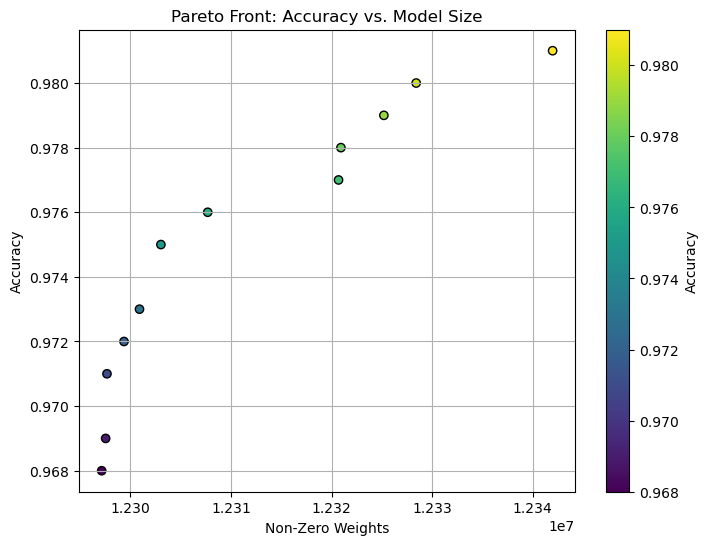

In [83]:
F = result_phase2.F
non_zero_weights = F[:, 0]
accuracies = 1 - F[:, 1]

plt.figure(figsize=(8, 6))
sc = plt.scatter(non_zero_weights, accuracies, c=accuracies, cmap='viridis', edgecolors='black')
plt.colorbar(sc, label='Accuracy')  # Optional: add a colorbar to interpret colors
plt.xlabel("Non-Zero Weights")
plt.ylabel("Accuracy")
plt.title("Pareto Front: Accuracy vs. Model Size")
plt.grid(True)
plt.show()

In [84]:
print("📊 Pareto Front Results:")
for i, (acc, nz) in enumerate(zip(accuracies, non_zero_weights)):
    print(f"[{i:02d}] Optimization Accuracy: {acc:.4f} | Non-Zero Weights: {int(nz)}")

📊 Pareto Front Results:
[00] Optimization Accuracy: 0.9800 | Non-Zero Weights: 12328413
[01] Optimization Accuracy: 0.9790 | Non-Zero Weights: 12325204
[02] Optimization Accuracy: 0.9730 | Non-Zero Weights: 12300914
[03] Optimization Accuracy: 0.9680 | Non-Zero Weights: 12297157
[04] Optimization Accuracy: 0.9780 | Non-Zero Weights: 12320935
[05] Optimization Accuracy: 0.9750 | Non-Zero Weights: 12303042
[06] Optimization Accuracy: 0.9770 | Non-Zero Weights: 12320698
[07] Optimization Accuracy: 0.9810 | Non-Zero Weights: 12341974
[08] Optimization Accuracy: 0.9690 | Non-Zero Weights: 12297549
[09] Optimization Accuracy: 0.9710 | Non-Zero Weights: 12297680
[10] Optimization Accuracy: 0.9760 | Non-Zero Weights: 12307695
[11] Optimization Accuracy: 0.9720 | Non-Zero Weights: 12299375


In [85]:
def cache_top10_phase2_models_and_metrics_2(result, base_model, conv_layer_names, val_loader, test_loader):
    
    genomes = []
    validation_accuracies = []
    test_accuracies = []
    non_zero_weights_list = []
    optimization_accuracies = []

    # === Step 1: Get top 10 individuals by optimization accuracy ===
    opt_acc_all = 1 - result.F[:, 1]  # Optimization accuracy = 1 - classification error
    top_indices = np.argsort(-opt_acc_all)[:15]  # Top 10 highest accuracy

    for i in top_indices:
        genome_vector = result.X[i]
        genome = []

        # Decode genome: list of (rᵢ, cᵢ)
        for j in range(0, len(genome_vector), 2):
            r = round(float(genome_vector[j]), 2)
            c = int(genome_vector[j + 1])
            genome.append((r, c))

        try:
            # Generate masks and apply
            filter_masks = generate_masks_from_individual(base_model, val_loader, genome, conv_layer_names)
            pruned_model = apply_filter_masks(base_model, filter_masks)

            # Validation accuracy
            pruned_model.eval()
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = pruned_model(inputs)
                    _, predicted = outputs.max(1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)
            val_acc = correct_val / total_val

            # Test accuracy
            correct_test, total_test = 0, 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = pruned_model(inputs)
                    _, predicted = outputs.max(1)
                    correct_test += (predicted == labels).sum().item()
                    total_test += labels.size(0)
            test_acc = correct_test / total_test

            # Non-zero weights
            non_zero = sum((p != 0).sum().item() for p in pruned_model.parameters())

            # Optimization accuracy (from NSGA-II run)
            opt_acc = opt_acc_all[i]

            # Store
            genomes.append(genome)
            validation_accuracies.append(val_acc)
            test_accuracies.append(test_acc)
            non_zero_weights_list.append(non_zero)
            optimization_accuracies.append(opt_acc)

            print(f"[{i:02d}] ✓ Opt Acc: {opt_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f} | Non-Zero: {non_zero}")

        except Exception as e:
            print(f"[{i:02d}] ❌ Error during caching: {e}")
            genomes.append(genome)
            validation_accuracies.append(0.0)
            test_accuracies.append(0.0)
            non_zero_weights_list.append(1e7)
            optimization_accuracies.append(opt_acc_all[i])

    # === Save everything ===
    np.save(os.path.join(save_dir_2, "validation_accuracies.npy"), validation_accuracies)
    np.save(os.path.join(save_dir_2, "test_accuracies.npy"), test_accuracies)
    np.save(os.path.join(save_dir_2, "non_zero_weights.npy"), non_zero_weights_list)
    np.save(os.path.join(save_dir_2, "cached_genomes_phase2.npy"), np.array(genomes, dtype=object))

    # CSV summary
    df = pd.DataFrame(genomes, columns=[f"Layer_{i}" for i in range(len(conv_layer_names))])
    df["Optimization Accuracy"] = optimization_accuracies
    df["Validation Accuracy"] = validation_accuracies
    df["Test Accuracy"] = test_accuracies
    df["Non-Zero Weights"] = non_zero_weights_list
    df.to_csv(os.path.join(save_dir_2, "cached_metrics_phase2.csv"), index=False)

    print(f"\n✅ Top 10 Phase 2 metrics saved to: {save_dir_2}/cached_metrics_phase2.csv")

    return genomes, validation_accuracies, test_accuracies, non_zero_weights_list

In [86]:
genomes, val_accs, test_accs, nonzeros = cache_top10_phase2_models_and_metrics_2(
    result=result_phase2,
    base_model=pruned_model_copy,
    conv_layer_names=list(extract_conv2d_layers(pruned_model_copy).keys()),
    val_loader=validation_loader,
    test_loader=test_loader
)

[07] ✓ Opt Acc: 0.9810 | Val Acc: 0.9815 | Test Acc: 0.9286 | Non-Zero: 12347994
[00] ✓ Opt Acc: 0.9800 | Val Acc: 0.9805 | Test Acc: 0.9266 | Non-Zero: 12333808
[01] ✓ Opt Acc: 0.9790 | Val Acc: 0.9795 | Test Acc: 0.9264 | Non-Zero: 12330103
[04] ✓ Opt Acc: 0.9780 | Val Acc: 0.9790 | Test Acc: 0.9268 | Non-Zero: 12326536
[06] ✓ Opt Acc: 0.9770 | Val Acc: 0.9795 | Test Acc: 0.9268 | Non-Zero: 12324985
[10] ✓ Opt Acc: 0.9760 | Val Acc: 0.9760 | Test Acc: 0.9210 | Non-Zero: 12315207
[05] ✓ Opt Acc: 0.9750 | Val Acc: 0.9745 | Test Acc: 0.9200 | Non-Zero: 12310813
[02] ✓ Opt Acc: 0.9730 | Val Acc: 0.9740 | Test Acc: 0.9198 | Non-Zero: 12309732
[11] ✓ Opt Acc: 0.9720 | Val Acc: 0.9730 | Test Acc: 0.9191 | Non-Zero: 12307254
[09] ✓ Opt Acc: 0.9710 | Val Acc: 0.9715 | Test Acc: 0.9153 | Non-Zero: 12305534
[08] ✓ Opt Acc: 0.9690 | Val Acc: 0.9710 | Test Acc: 0.9159 | Non-Zero: 12304294
[03] ✓ Opt Acc: 0.9680 | Val Acc: 0.9715 | Test Acc: 0.9155 | Non-Zero: 12304642

✅ Top 10 Phase 2 metrics sa

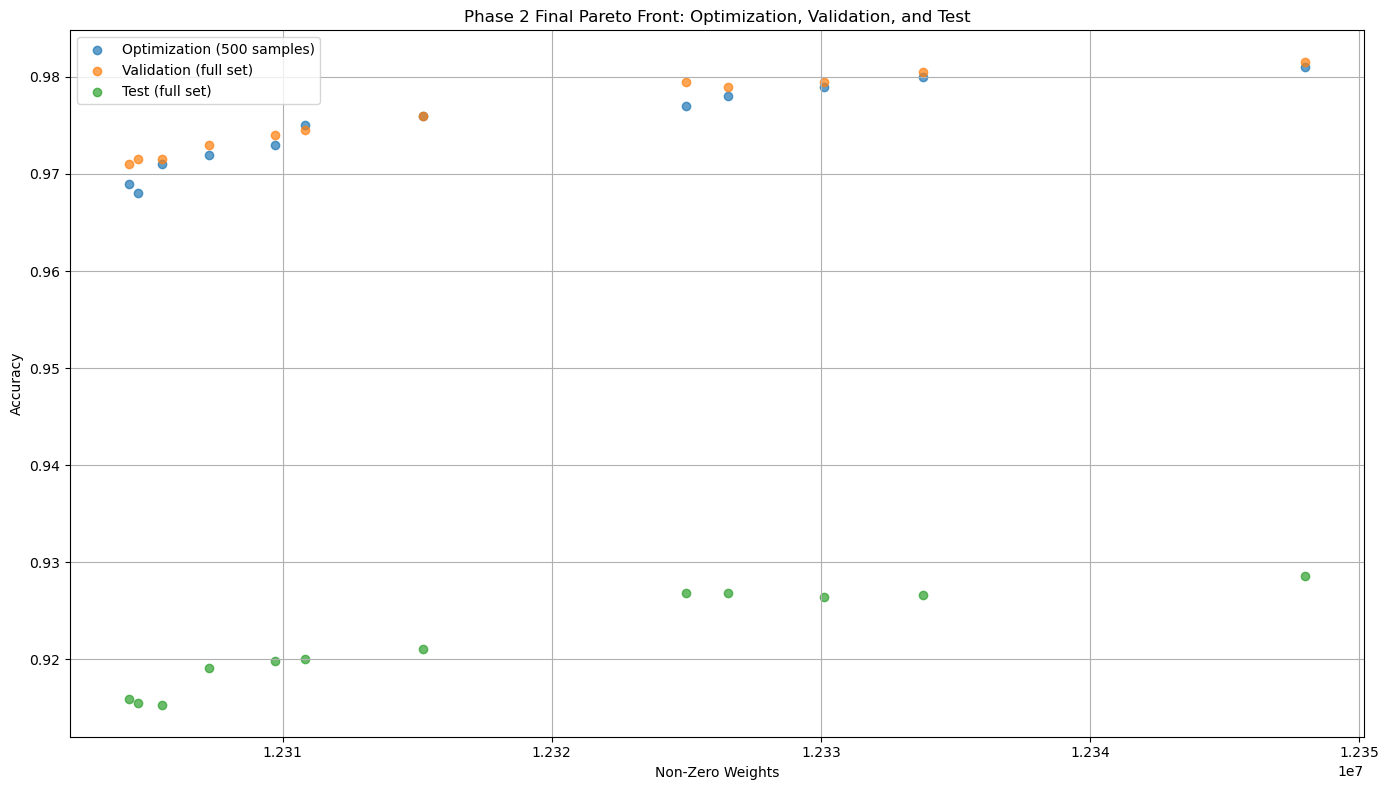

✅ Phase 2 Pareto front plot saved at: resnet101_phase_2_saved_models\final_pareto_front_phase2.png


In [87]:
def plot_phase2_final_pareto_front(result, save_dir_2):
    
    # Load cached metrics
    validation_accuracies = np.load(os.path.join(save_dir_2, "validation_accuracies.npy"))
    test_accuracies = np.load(os.path.join(save_dir_2, "test_accuracies.npy"))
    non_zero_weights_list = np.load(os.path.join(save_dir_2, "non_zero_weights.npy"))

    # Get optimization accuracy from result
    opt_acc_all = 1 - result.F[:, 1]
    top_indices = np.argsort(-opt_acc_all)[:15]
    optimization_accuracies = opt_acc_all[top_indices]

    if len(optimization_accuracies) == 0 or len(validation_accuracies) == 0 or len(test_accuracies) == 0:
        print("❌ Error: One or more accuracy lists are empty.")
        return

    plt.figure(figsize=(14, 8))

    plt.scatter(non_zero_weights_list, optimization_accuracies, label="Optimization (500 samples)", alpha=0.7)
    plt.scatter(non_zero_weights_list, validation_accuracies, label="Validation (full set)", alpha=0.7)
    plt.scatter(non_zero_weights_list, test_accuracies, label="Test (full set)", alpha=0.7)

    plt.xlabel("Non-Zero Weights")
    plt.ylabel("Accuracy")
    plt.title("Phase 2 Final Pareto Front: Optimization, Validation, and Test")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plot_path = os.path.join(save_dir_2, "final_pareto_front_phase2.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"✅ Phase 2 Pareto front plot saved at: {plot_path}")

plot_phase2_final_pareto_front(result_phase2, save_dir_2)

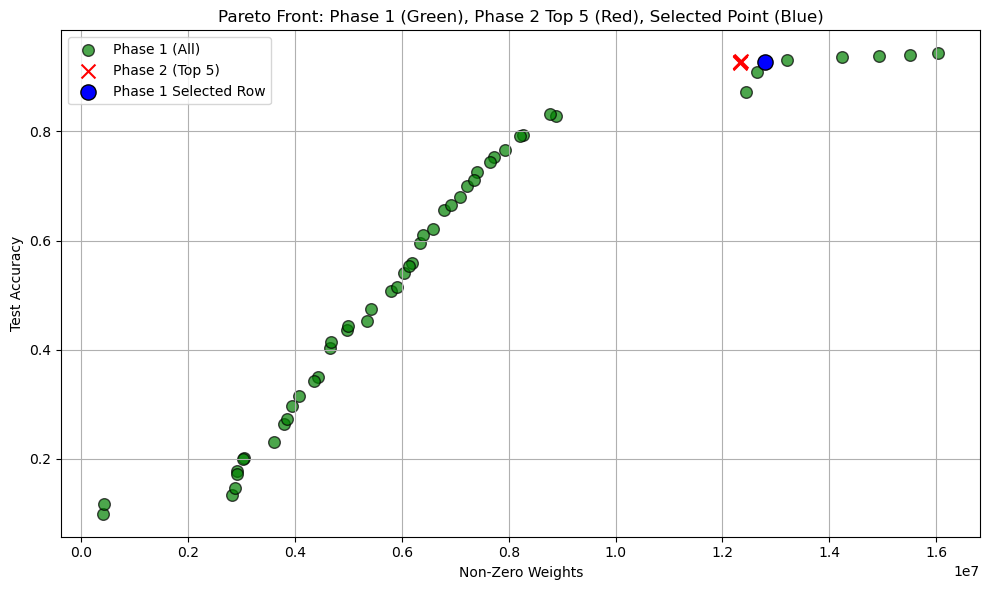

✅ Final custom plot saved to: C:\Users\Zahaak\Desktop\AI - Workspace\MOOP_V6\resnet101_phase_2_saved_models\combined_pareto_front_top5_selected.png


In [88]:
# === Load Phase 1 ===
phase1_path = r"C:\Users\Zahaak\Desktop\AI - Workspace\MOOP_V6\resnet101_phase_1_saved_models\cached_metrics.csv"
phase1_df = pd.read_csv(phase1_path)
phase1_nonzeros = phase1_df["Non-Zero Weights"].values
phase1_test_acc = phase1_df["Test Accuracy"].values

# === Load Phase 2 ===
phase2_path = r"C:\Users\Zahaak\Desktop\AI - Workspace\MOOP_V6\resnet101_phase_2_saved_models\cached_metrics_phase2.csv"
phase2_df = pd.read_csv(phase2_path)
phase2_nonzeros = phase2_df["Non-Zero Weights"].values
phase2_test_acc = phase2_df["Test Accuracy"].values

# === Load Selected Row from Phase 2 ===
selected_row_path = r"C:\Users\Zahaak\Desktop\AI - Workspace\MOOP_V6\resnet101_phase_2_saved_models\selected_row_phase2.csv"
selected_row_df = pd.read_csv(selected_row_path)
target_weight = selected_row_df["#Non-Zero Weights"].values[0]

# === Find Closest Phase 1 Match ===
phase1_df_sorted = phase1_df.sort_values(by="Non-Zero Weights")
closest_idx = (phase1_df_sorted["Non-Zero Weights"] - target_weight).abs().idxmin()
closest_row = phase1_df_sorted.loc[closest_idx]
closest_weight = closest_row["Non-Zero Weights"]
closest_acc = closest_row["Test Accuracy"]

# === Get Top 5 Phase 2 by Accuracy ===
top5_indices = np.argsort(-phase2_test_acc)[:5]
top5_nonzeros = phase2_nonzeros[top5_indices]
top5_test_acc = phase2_test_acc[top5_indices]

# === Plot ===
plt.figure(figsize=(10, 6))

# Phase 1 (green)
plt.scatter(phase1_nonzeros, phase1_test_acc, label="Phase 1 (All)", color='green', edgecolors='black', alpha=0.7, s=70)

# Phase 2 Top 5 (red)
plt.scatter(top5_nonzeros, top5_test_acc, label="Phase 2 (Top 5)", color='red', marker='x', s=100)

# Selected Phase 1 Row (blue)
plt.scatter([closest_weight], [closest_acc], label="Phase 1 Selected Row", color='blue', marker='o', edgecolors='black', s=120)

plt.xlabel("Non-Zero Weights")
plt.ylabel("Test Accuracy")
plt.title("Pareto Front: Phase 1 (Green), Phase 2 Top 5 (Red), Selected Point (Blue)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# === Save ===
save_path = r"C:\Users\Zahaak\Desktop\AI - Workspace\MOOP_V6\resnet101_phase_2_saved_models\combined_pareto_front_top5_selected.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Final custom plot saved to: {save_path}")